### Comparing L1000 and Cell painting compound's values/scores based on their replicates

- Visualizing the median scores of cell painting cpds vs L1000 cpds using scatter plot.

- Visualizing the median scores distribution of both cell painting and L1000.

- Visualizing the signature strength of Cell painting vs L1000 compounds using scatter plot.

- Visualizing the MAS (Morphological activity score) of Cell painting vs TAS (Transcriptional activity score) L1000 compounds using scatter plot.

In [1]:
import os
import pathlib
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle
sns.set_style("darkgrid")
##sns.set_palette(["red", "green", "orange","blue","gray","purple"])
sns.set_context("talk")

In [2]:
cp_level4_path = '../cell_painting/cellpainting_lvl4_cpd_replicate_datasets'
L1000_level4_path = '../L1000/L1000_lvl4_cpd_replicate_datasets'

In [3]:
# Load common compounds
common_file = pathlib.Path(
    "..", "..", "..", "6.paper_figures", "data", "significant_compounds_by_threshold_both_assays.tsv.gz"
)
common_df = pd.read_csv(common_file, sep="\t")

common_compounds = common_df.compound.unique()
print(len(common_compounds))

1327


In [4]:
df_cp_med = pd.read_csv(os.path.join(cp_level4_path, 'cpd_replicate_median_scores.csv'))
df_cp_med.cpd = df_cp_med.cpd.str.lower()
df_cp_med = df_cp_med.query("cpd in @common_compounds")

df_L1_med = pd.read_csv(os.path.join(L1000_level4_path, 'cpd_replicate_median_scores.csv'))
df_L1_med.cpd = df_L1_med.cpd.str.lower()
df_L1_med = df_L1_med.query("cpd in @common_compounds")

In [5]:
df_cp_pvals = pd.read_csv(os.path.join(cp_level4_path, 'cpd_replicate_p_values.csv'))
df_cp_pvals.cpd = df_cp_pvals.cpd.str.lower()
df_cp_pvals = df_cp_pvals.query("cpd in @common_compounds")

df_L1_pvals = pd.read_csv(os.path.join(L1000_level4_path, 'cpd_replicate_p_values.csv'))
df_L1_pvals.cpd = df_L1_pvals.cpd.str.lower()
df_L1_pvals = df_L1_pvals.query("cpd in @common_compounds")

In [6]:
df_cp_all = pd.read_csv(os.path.join(cp_level4_path, 'cp_all_scores.csv'))
df_cp_all.cpd = df_cp_all.cpd.str.lower()
df_cp_all = df_cp_all.query("cpd in @common_compounds")

df_L1_all = pd.read_csv(os.path.join(L1000_level4_path, 'L1000_all_scores.csv'))
df_L1_all.cpd = df_L1_all.cpd.str.lower()
df_L1_all = df_L1_all.query("cpd in @common_compounds")

In [7]:
with open(os.path.join(cp_level4_path, 'CP_dmso_95_percentile_MAS.pickle'), 'rb') as handle:
    cp_dmso_95pct = pickle.load(handle)
with open(os.path.join(L1000_level4_path, 'L1000_dmso_95_percentile_TAS.pickle'), 'rb') as handle:
    L1_dmso_95pct = pickle.load(handle)

In [8]:
with open(os.path.join(cp_level4_path, 'null_dist_medians_per_dose.pickle'), 'rb') as handle:
    null_dist_med_cp = pickle.load(handle)
    
with open(os.path.join(L1000_level4_path, 'null_dist_medians_per_dose.pickle'), 'rb') as handle:
    null_dist_med_L1000 = pickle.load(handle)

In [9]:
def reproducible_dose(df, df_med):
    """
    This function computes how many reproducible median correlation scores 
    each compound has across all doses, (out of the 6 doses based on p-values)
    """
    df_new = df.set_index('cpd').rename_axis(None, axis=0).drop(['no_of_replicates'], axis = 1).copy()
    cpd_values = {cpd:sum(df_new.loc[cpd] <= 0.05) for cpd in df_new.index}
    df['No_of_reproducible_doses'] = cpd_values.values()
    df_med['No_of_reproducible_doses'] = cpd_values.values()
    
    return df, df_med

In [10]:
df_cp_pvals, df_cp_med = reproducible_dose(df_cp_pvals, df_cp_med)
df_L1_pvals, df_L1_med = reproducible_dose(df_L1_pvals, df_L1_med)

In [11]:
def rename_cols(df):
    'Rename columns from dose number to actual doses'
    
    df.rename(columns= {'dose_1' : '0.04 uM', 'dose_2':'0.12 uM', 'dose_3':'0.37 uM',
                        'dose_4': '1.11 uM', 'dose_5':'3.33 uM', 'dose_6':'10 uM'}, inplace = True)
    return df

In [12]:
df_cp_med = rename_cols(df_cp_med)
df_L1_med = rename_cols(df_L1_med)

In [13]:
df_cp_pvals = rename_cols(df_cp_pvals)
df_L1_pvals = rename_cols(df_L1_pvals)

In [14]:
def melt_df(df, col_name):
    """Reconstruct the dataframe into 4 columns: cpd, cpd_size, No_of_reproducible_doses, doses"""
    df_melt = df.melt(id_vars=['cpd', 'no_of_replicates', 'No_of_reproducible_doses'], var_name="dose", value_name=col_name)
    return df_melt

In [15]:
def melt_L1000_CP(df_cp,df_L1):
    """
    Reconstruct Cell painting and L1000 dataframes, 
    by tranforming the dose columns into vertical rows
    """
    cp_cpd = df_cp.cpd.values.tolist()
    L1_cpd = df_L1.cpd.values.tolist()
    all_cpds = [x for x in cp_cpd if x in L1_cpd]
    df_cp_med =df_cp.loc[df_cp['cpd'].isin(all_cpds)].reset_index(drop=True)
    df_L1_med = df_L1.loc[df_L1['cpd'].isin(all_cpds)].reset_index(drop=True)
    df_cp_melt = melt_df(df_cp_med, 'Cell painting')
    df_L1_melt = melt_df(df_L1_med,'L1000')
    
    return df_cp_melt, df_L1_melt

In [16]:
df_cp_melt, df_L1_melt = melt_L1000_CP(df_cp_med,df_L1_med)

In [17]:
len(df_L1_melt['cpd'].unique())

1327

In [18]:
df_L1_melt.head()

cpd  no_of_replicates  \
0  17-hydroxyprogesterone-caproate                 3   
1                    2-iminobiotin                 2   
2                3-amino-benzamide                 3   
3                 3-deazaadenosine                 2   
4                          abt-737                 3   

   No_of_reproducible_doses     dose     L1000  
0                         3  0.04 uM  0.024738  
1                         1  0.04 uM -0.133693  
2                         1  0.04 uM  0.051959  
3                         0  0.04 uM  0.065967  
4                         1  0.04 uM  0.016400

In [19]:
def merge_L1000_CP(df_cp, df_L1):
    
    """Merge L1000 and Cell painting dataframes based on compounds and doses found in both dataframes"""
    
    df_cp_new = df_cp.rename(columns={"Cell painting": "median scores"})
    df_cp_new['profile_tech'] = 'Cell painting'
    df_L1_new = df_L1.rename(columns={"L1000": "median scores"})
    df_L1_new['profile_tech'] = 'L1000'
    df_cp_L1 = pd.concat([df_cp_new, df_L1_new], ignore_index=True)
    
    df_cp_nw = df_cp.rename(columns={'no_of_replicates': "no_of_replicates_CP", 
                          "No_of_reproducible_doses": "No_of_reproducible_doses-Cell painting"})
    df_L1_nw = df_L1.rename(columns={'no_of_replicates': "no_of_replicates_L1000",
                          "No_of_reproducible_doses": "No_of_reproducible_doses-L1000"})
    df_L1_cp_merge = df_cp_nw.merge(df_L1_nw, on=['cpd', 'dose'])
    return df_cp_L1, df_L1_cp_merge

In [20]:
df_cp_L1_melt, df_L1_cp_med = merge_L1000_CP(df_cp_melt, df_L1_melt)

In [21]:
df_cp_L1_melt.head()

cpd  no_of_replicates  \
0  17-hydroxyprogesterone-caproate                 5   
1                    2-iminobiotin                 5   
2                3-amino-benzamide                 5   
3                 3-deazaadenosine                 5   
4                          abt-737                 5   

   No_of_reproducible_doses     dose  median scores   profile_tech  
0                         6  0.04 uM       0.060655  Cell painting  
1                         1  0.04 uM       0.042700  Cell painting  
2                         5  0.04 uM       0.104273  Cell painting  
3                         3  0.04 uM       0.010217  Cell painting  
4                         5  0.04 uM       0.004470  Cell painting

In [22]:
cp_95pct = [np.percentile(null_dist_med_cp[keys],95) for keys in null_dist_med_cp]

In [23]:
L1000_95pct = [np.percentile(null_dist_med_L1000[keys],95) for keys in null_dist_med_L1000]

### - Plot median scores of L1000 vs Cell painting compound replicates

In [24]:
def plot_median_scores(df, L1000_95pct, cp_95pct, title, path, file_name, hue = 'Cell painting', 
                       alp =0.4, size =(50,300)):
    
    """Plot median scores of L1000 versus Cell painting"""
    
    if not os.path.exists(path):
        os.mkdir(path)
    rel_plt = sns.relplot(data=df, x="Cell painting", y="L1000", col="dose", 
                          hue = 'No_of_reproducible_doses-'+ hue, size = 'No_of_reproducible_doses-'+ hue, sizes= size,
                          kind="scatter", palette=sns.color_palette("crest", as_cmap=True), 
                          col_wrap=3, height=5.5, aspect=1.3, alpha = alp)
    rel_plt.fig.suptitle(title)
    rel_plt.fig.subplots_adjust(top=.91)
    for idx, val in enumerate(zip(L1000_95pct, cp_95pct)):
        rel_plt.axes[idx].axhline(y = val[0], ls='--', color = 'black', alpha = 0.7, label = '95th null distribution')
        rel_plt.axes[idx].axvline(x = val[1], ls='--', color = 'black', alpha = 0.7)
    rel_leg = rel_plt._legend
    rel_leg.set_bbox_to_anchor([0.90, 0.51])
    plt.legend(bbox_to_anchor=(1.01, 0.505), loc='lower left')
    rel_plt.legend.set_title('Number of\nreproducible\ndoses\n' + '('+ hue +')')
    plt.savefig(os.path.join(path, file_name))
    plt.show()

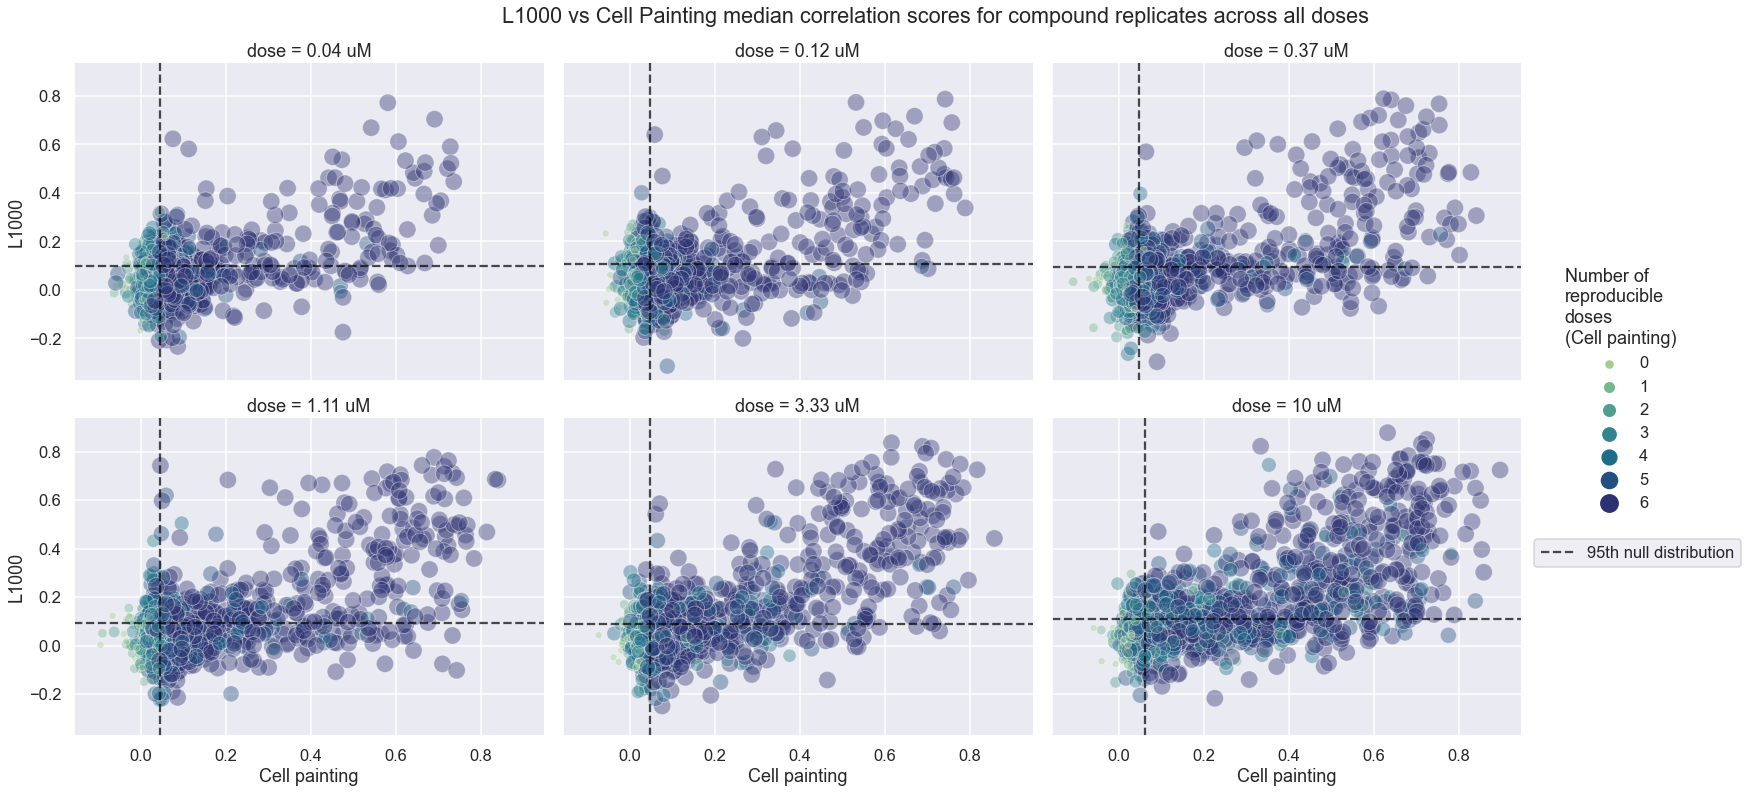

In [25]:
plot_median_scores(df_L1_cp_med, L1000_95pct, cp_95pct, 
                   "L1000 vs Cell Painting median correlation scores for compound replicates across all doses",
                   'L1000_cp_figures', 'median_scores_plot_1a.png')

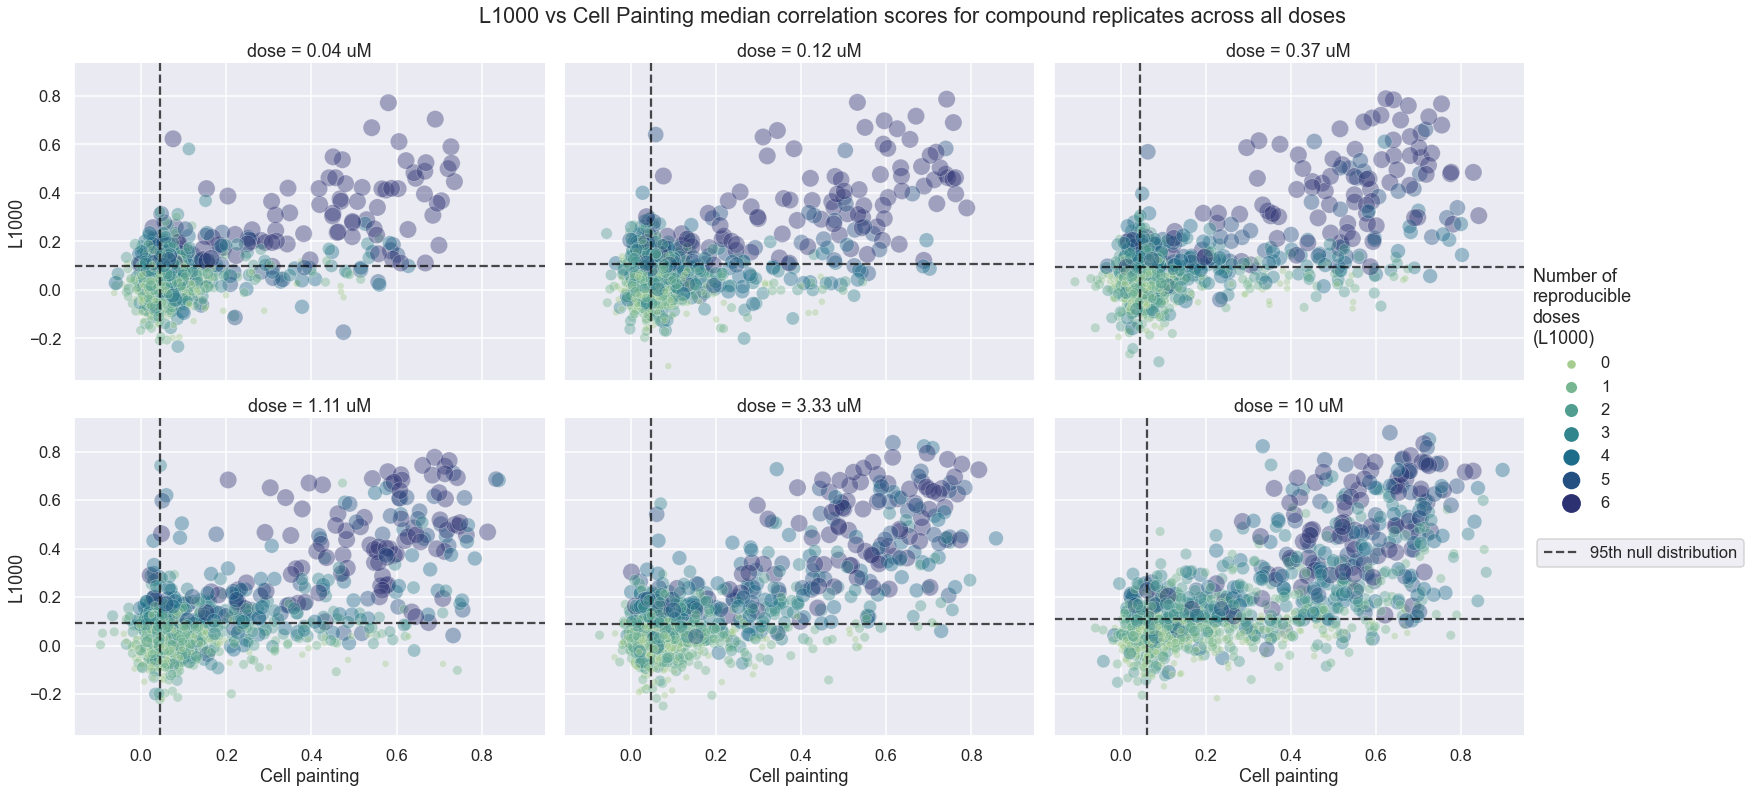

In [26]:
plot_median_scores(df_L1_cp_med, L1000_95pct, cp_95pct, 
                   "L1000 vs Cell Painting median correlation scores for compound replicates across all doses",
                   'L1000_cp_figures', 'median_scores_plot_1b.png', hue = 'L1000')

In [27]:
df_L1_cp_med.head()

cpd  no_of_replicates_CP  \
0  17-hydroxyprogesterone-caproate                    5   
1                    2-iminobiotin                    5   
2                3-amino-benzamide                    5   
3                 3-deazaadenosine                    5   
4                          abt-737                    5   

   No_of_reproducible_doses-Cell painting     dose  Cell painting  \
0                                       6  0.04 uM       0.060655   
1                                       1  0.04 uM       0.042700   
2                                       5  0.04 uM       0.104273   
3                                       3  0.04 uM       0.010217   
4                                       5  0.04 uM       0.004470   

   no_of_replicates_L1000  No_of_reproducible_doses-L1000     L1000  
0                       3                               3  0.024738  
1                       2                               1 -0.133693  
2                       3                               1  0.051959  
3                       2                               0  0.065967  
4                       3                               1  0.016400

In [28]:
df_highcp_lowL1_med = df_L1_cp_med[(df_L1_cp_med['L1000'] < 0.2) & \
                                   (df_L1_cp_med['Cell painting'] > 0.8)].reset_index(drop=True).copy()

In [29]:
df_highcp_lowL1_med

cpd  no_of_replicates_CP  No_of_reproducible_doses-Cell painting  \
0  clofarabine                    5                                       6   
1   amiodarone                    5                                       5   

      dose  Cell painting  no_of_replicates_L1000  \
0  0.37 uM       0.802077                       3   
1    10 uM       0.839273                       3   

   No_of_reproducible_doses-L1000     L1000  
0                               4  0.144169  
1                               3  0.184575

In [30]:
# plot_median_scores(df_highcp_lowL1_med, L1000_95pct, cp_95pct, 
#                    "Low L1000 vs High Cell Painting median correlation scores for compound replicates",
#                    'L1000_cp_figures', 'lowL1000_HighCP_med_scores1b.png', hue = 'Cell painting', alp =0.7)

In [31]:
# plot_median_scores(df_highcp_lowL1_med, L1000_95pct, cp_95pct, 
#                    "Low L1000 vs High Cell Painting median correlation scores for compound replicates",
#                    'L1000_cp_figures', 'lowL1000_HighCP_med_scores1b.png', hue = 'L1000', alp =0.7)

In [32]:
df_lowcp_highL1_med = df_L1_cp_med[(df_L1_cp_med['L1000'] > 0.4) & \
                                   (df_L1_cp_med['Cell painting'] < 0.2)].reset_index(drop=True).copy()

In [33]:
df_lowcp_highL1_med

cpd  no_of_replicates_CP  \
0   rho-kinase-inhibitor-iii[rockout]                    5   
1                           alvocidib                    5   
2                           lasalocid                    4   
3                     l-ergothioneine                    5   
4                           lasalocid                    4   
5                          rupatadine                    5   
6                     l-ergothioneine                    5   
7                         acrivastine                    5   
8                             amg-517                    5   
9                         enzastaurin                    5   
10                         gliclazide                    5   
11                           iniparib                    5   
12                    l-ergothioneine                    5   
13                         macitentan                    5   
14                  tetrahydrouridine                    5   
15                    l-ergothioneine                    5   
16                         rupatadine                    5   
17                        tofacitinib                    5   
18                            zd-7114                    5   

    No_of_reproducible_doses-Cell painting     dose  Cell painting  \
0                                        6  0.04 uM       0.112166   
1                                        6  0.04 uM       0.153591   
2                                        6  0.04 uM       0.075003   
3                                        6  0.12 uM       0.058396   
4                                        6  0.12 uM       0.076381   
5                                        5  0.12 uM       0.027660   
6                                        6  0.37 uM       0.063974   
7                                        3  1.11 uM       0.029043   
8                                        5  1.11 uM       0.059216   
9                                        4  1.11 uM       0.095641   
10                                       5  1.11 uM       0.176416   
11                                       5  1.11 uM       0.047734   
12                                       6  1.11 uM       0.049568   
13                                       6  1.11 uM       0.091236   
14                                       6  1.11 uM       0.045648   
15                                       6  3.33 uM       0.060725   
16                                       5  3.33 uM       0.064906   
17                                       6  3.33 uM       0.070028   
18                                       6    10 uM       0.092886   

    no_of_replicates_L1000  No_of_reproducible_doses-L1000     L1000  
0                        2                               3  0.581414  
1                        3                               6  0.417900  
2                        3                               6  0.623312  
3                        2                               5  0.640835  
4                        3                               6  0.469924  
5                        3                               4  0.400698  
6                        2                               5  0.569795  
7                        3                               4  0.432599  
8                        3                               4  0.620393  
9                        2                               4  0.504250  
10                       3                               5  0.459611  
11                       3                               6  0.461702  
12                       2                               5  0.598063  
13                       2                               4  0.445253  
14                       2                               3  0.742995  
15                       2                               5  0.542090  
16                       3                               4  0.433176  
17                       2                               3  0.585557  
18                       2                 

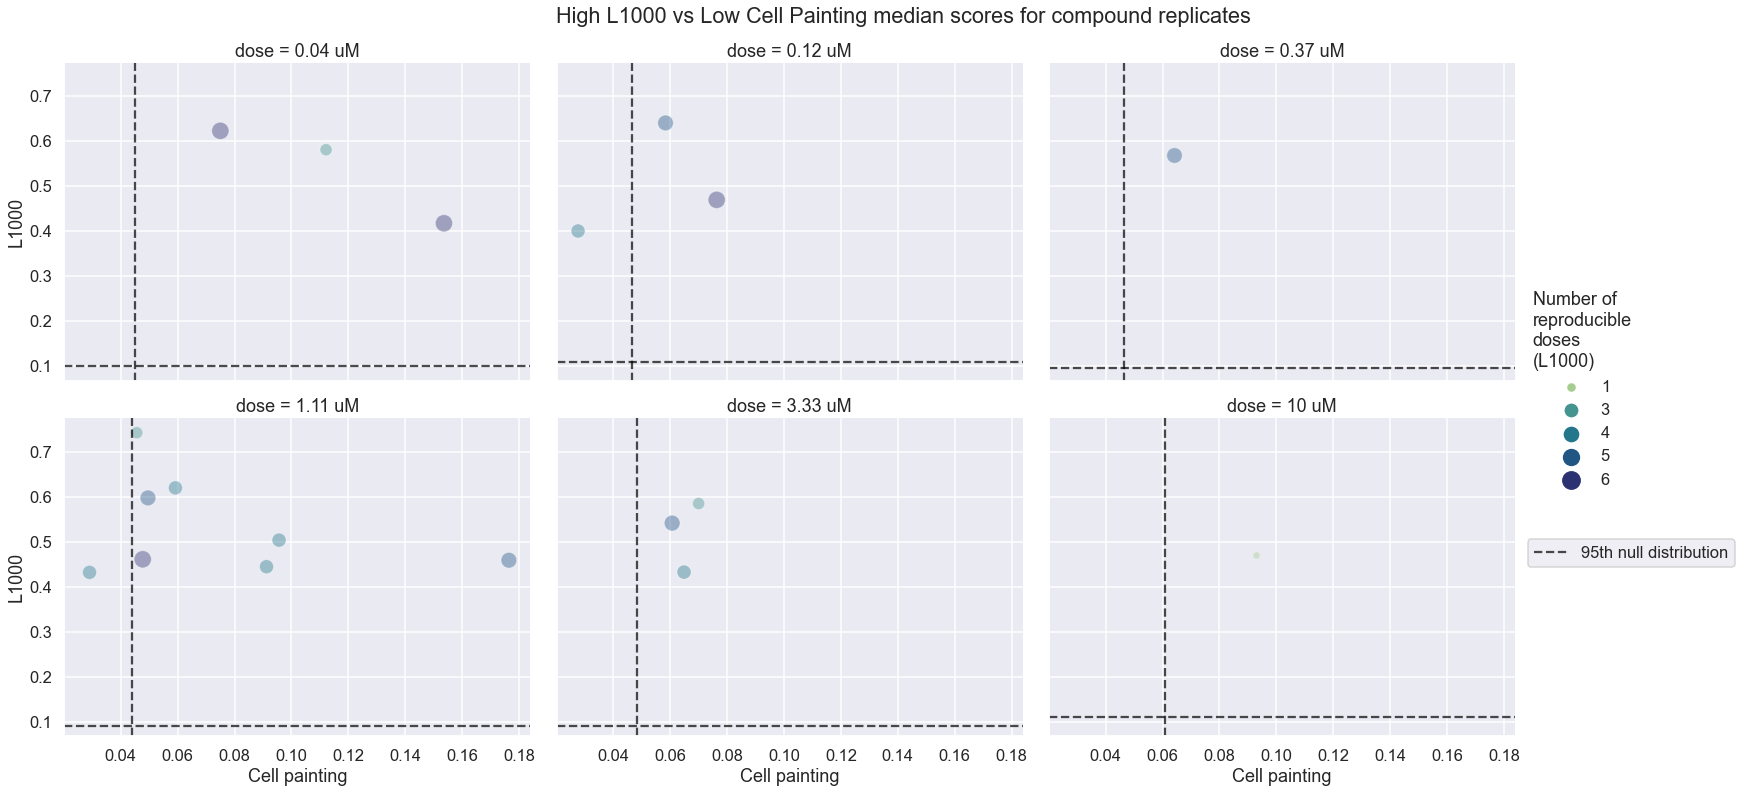

In [34]:
plot_median_scores(df_lowcp_highL1_med, L1000_95pct, cp_95pct, 
                   "High L1000 vs Low Cell Painting median scores for compound replicates",
                   'L1000_cp_figures', 'HighL1000_LowCP_med_scores1b.png', hue = 'L1000')

In [35]:
def plot_median_distribution(df, title, path, file_name, plot_type = "hist"):
    """
    This function plot the frequency distribution of the median scores 
    of compounds measured in cell painting and L1000
    """
    if not os.path.exists(path):
        os.mkdir(path)
    dist_plt = sns.displot(df, x = 'median scores', col = 'dose', col_wrap=3, hue='profile_tech',
                          palette = sns.set_palette(["blue","red"]), height=5.6, aspect=1.3, kind=plot_type, alpha=0.4)
    dist_plt.legend.set_title("")
    dist_plt.fig.suptitle(title)
    dist_plt.fig.subplots_adjust(top=.90)
    plt.savefig(os.path.join(path, file_name))
    plt.show()

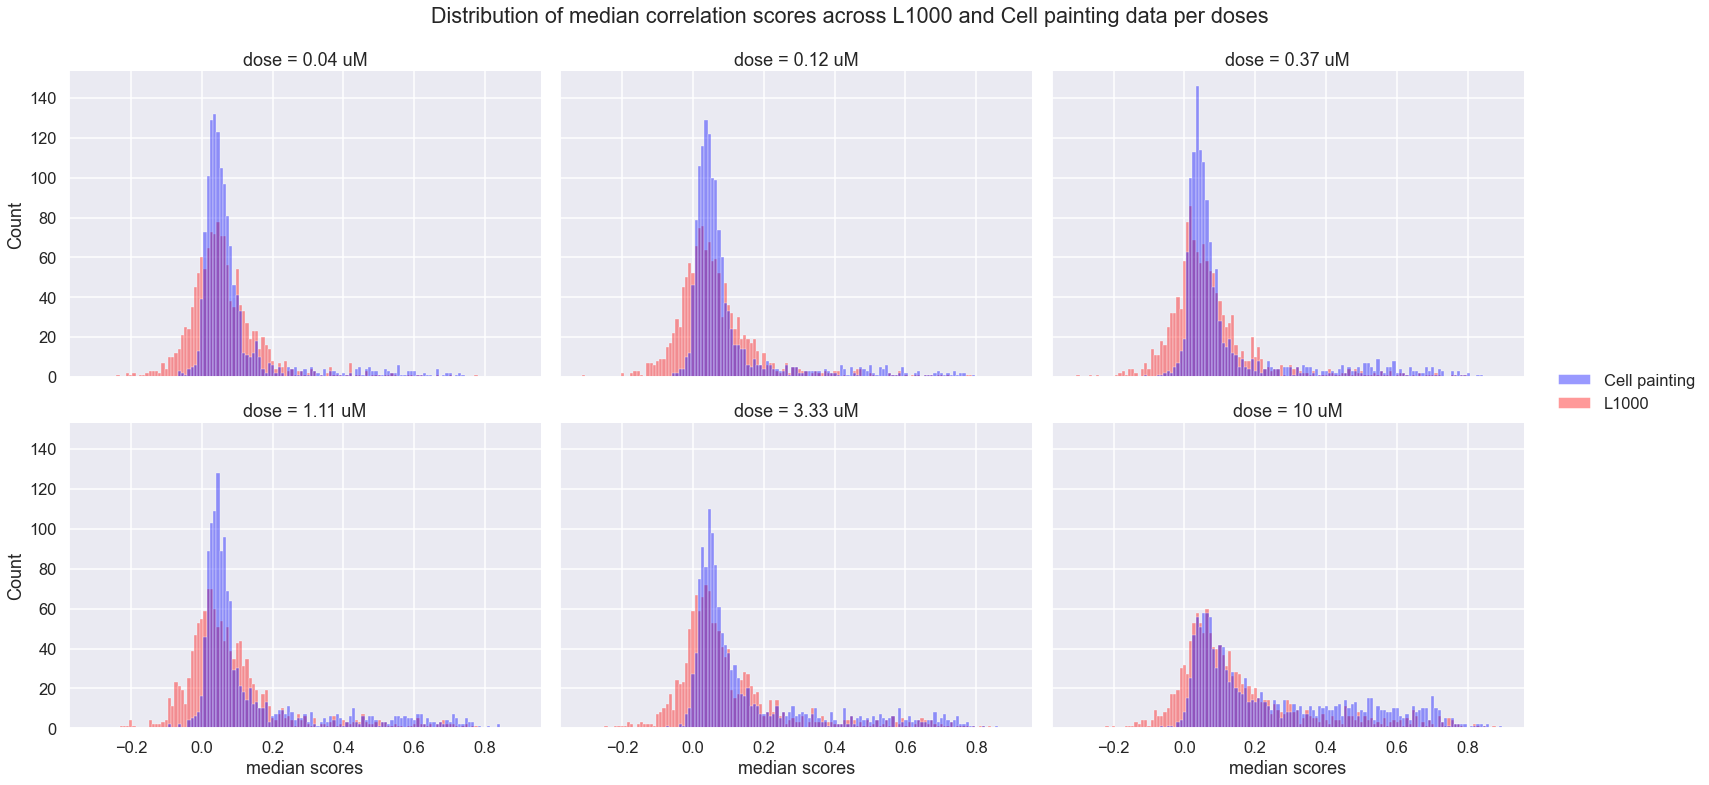

In [36]:
plot_median_distribution(df_cp_L1_melt, 'Distribution of median correlation scores across L1000 and Cell painting data per doses', 
                         'L1000_cp_figures', 'median_score_distribution.png', plot_type = "hist")

In [37]:
def plot_median_dist(df, path, file_name):
    
    """
    This function plot the frequency distribution of the median scores 
    of compounds measured in cell painting and L1000
    """
    if not os.path.exists(path):
        os.mkdir(path)
        
    dist = sns.displot(df, x="median scores", col="profile_tech", col_wrap=2, hue = 'dose', 
                       palette = sns.set_palette(["red", "green", "orange","blue","gray","purple"]), 
                       height=6.5, aspect=1.3, multiple="stack")
    dist.fig.suptitle('Distribution of median correlation scores across L1000 and Cell painting data per doses')
    dist.fig.subplots_adjust(top=.85)
    axes = dist.axes.flatten()
    axes[0].set_title("Cell Painting")
    axes[1].set_title("L1000")
    plt.savefig(os.path.join(path, file_name))
    plt.show()

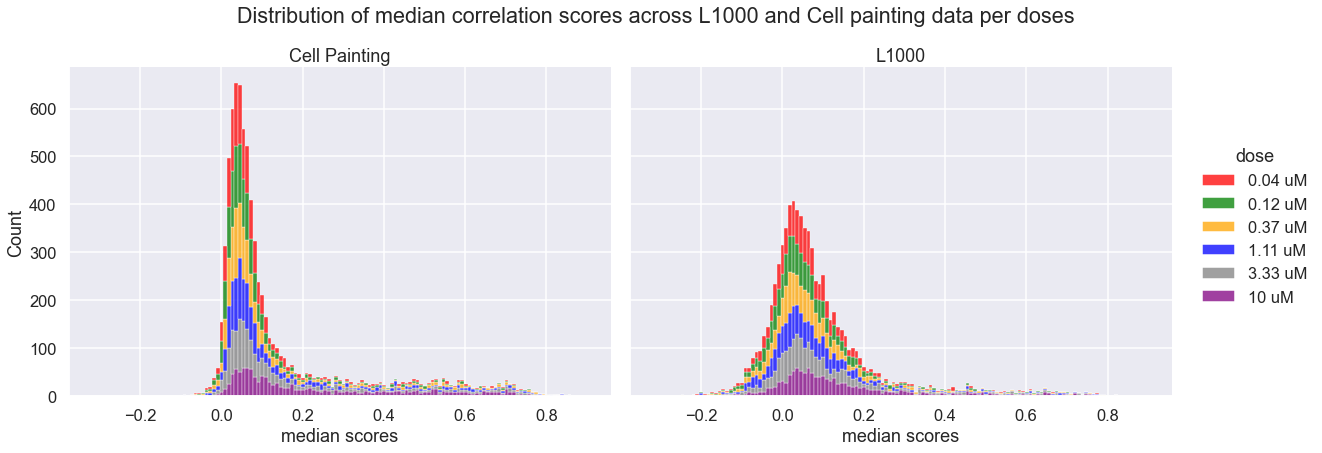

In [38]:
plot_median_dist(df_cp_L1_melt, 'L1000_cp_figures', 'median_score_dist.png')

### - Compounds with reproducible median correlation values (i.e. p_values below 0.05) in 1.11 - 10uM doses

In [39]:
def stat_significant_df(df_cp_pvalues, df_L1_pvalues, df_cp_medscores, df_L1_medscores):
    """
    This function compounds with reproducible median scores 
    across the last 3 doses (1.11-10uM) found in both cell painting and L1000
    """
    stat_cp_cpds = df_cp_pvalues[df_cp_pvalues['No_of_reproducible_doses'] >= 4]['cpd'].values.tolist()
    stat_L1_cpds = df_L1_pvalues[df_L1_pvalues['No_of_reproducible_doses'] >= 4]['cpd'].values.tolist()
    stat_cpds = [x for x in stat_cp_cpds if x in stat_L1_cpds]
    df_stat_cp = df_cp_medscores.loc[df_cp_medscores['cpd'].isin(stat_cpds)].reset_index(drop=True)
    df_stat_L1 = df_L1_medscores.loc[df_L1_medscores['cpd'].isin(stat_cpds)].reset_index(drop=True)
    
    return df_stat_cp, df_stat_L1

In [40]:
df_stat_cp, df_stat_L1 = stat_significant_df(df_cp_pvals, df_L1_pvals, df_cp_melt, df_L1_melt)

In [41]:
df_cp_L1_stat_melt, df_L1_cp_stat_med = merge_L1000_CP(df_stat_cp, df_stat_L1)

In [42]:
df_L1_cp_stat_med.head()

cpd  no_of_replicates_CP  No_of_reproducible_doses-Cell painting  \
0    at-7519                    5                                       6   
1   azd-5438                    5                                       6   
2   azd-8330                    5                                       6   
3    bi-2536                    5                                       6   
4  bibx-1382                    5                                       5   

      dose  Cell painting  no_of_replicates_L1000  \
0  0.04 uM       0.143624                       3   
1  0.04 uM       0.080211                       3   
2  0.04 uM       0.529970                       3   
3  0.04 uM       0.705653                       3   
4  0.04 uM       0.074880                       3   

   No_of_reproducible_doses-L1000     L1000  
0                               4  0.123918  
1                               6  0.258015  
2                               6  0.289763  
3                               6  0.368031  
4                               4  0.059230

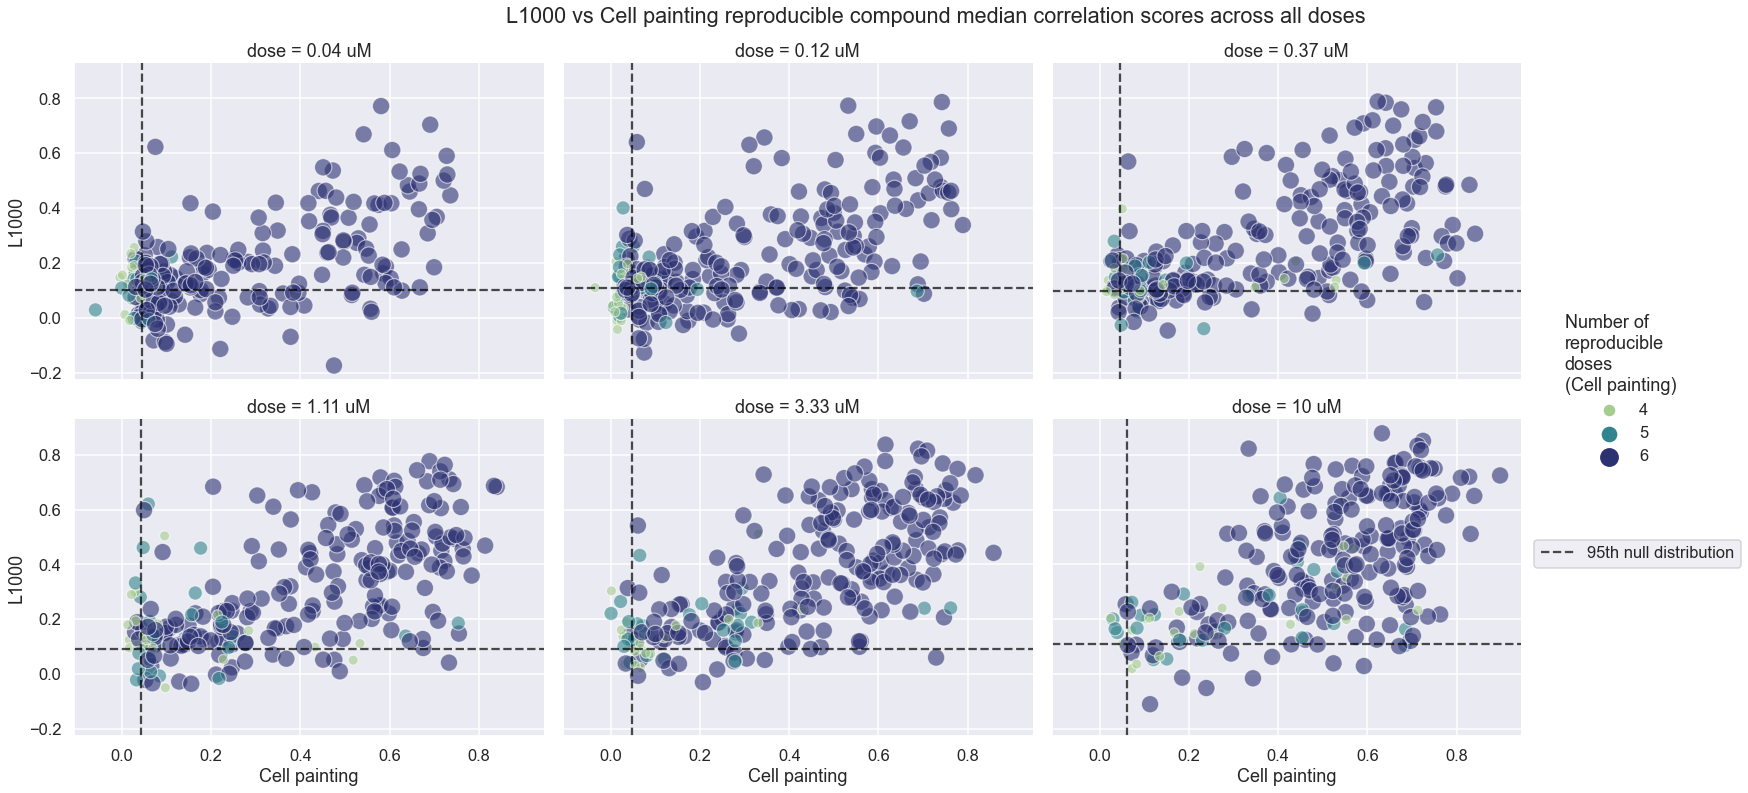

In [43]:
plot_median_scores(df_L1_cp_stat_med, L1000_95pct, cp_95pct, 
                   "L1000 vs Cell painting reproducible compound median correlation scores across all doses",
                   'L1000_cp_figures', 'stat_sign_med_scores_plot1a.png',  alp =0.6, size =(100,300))

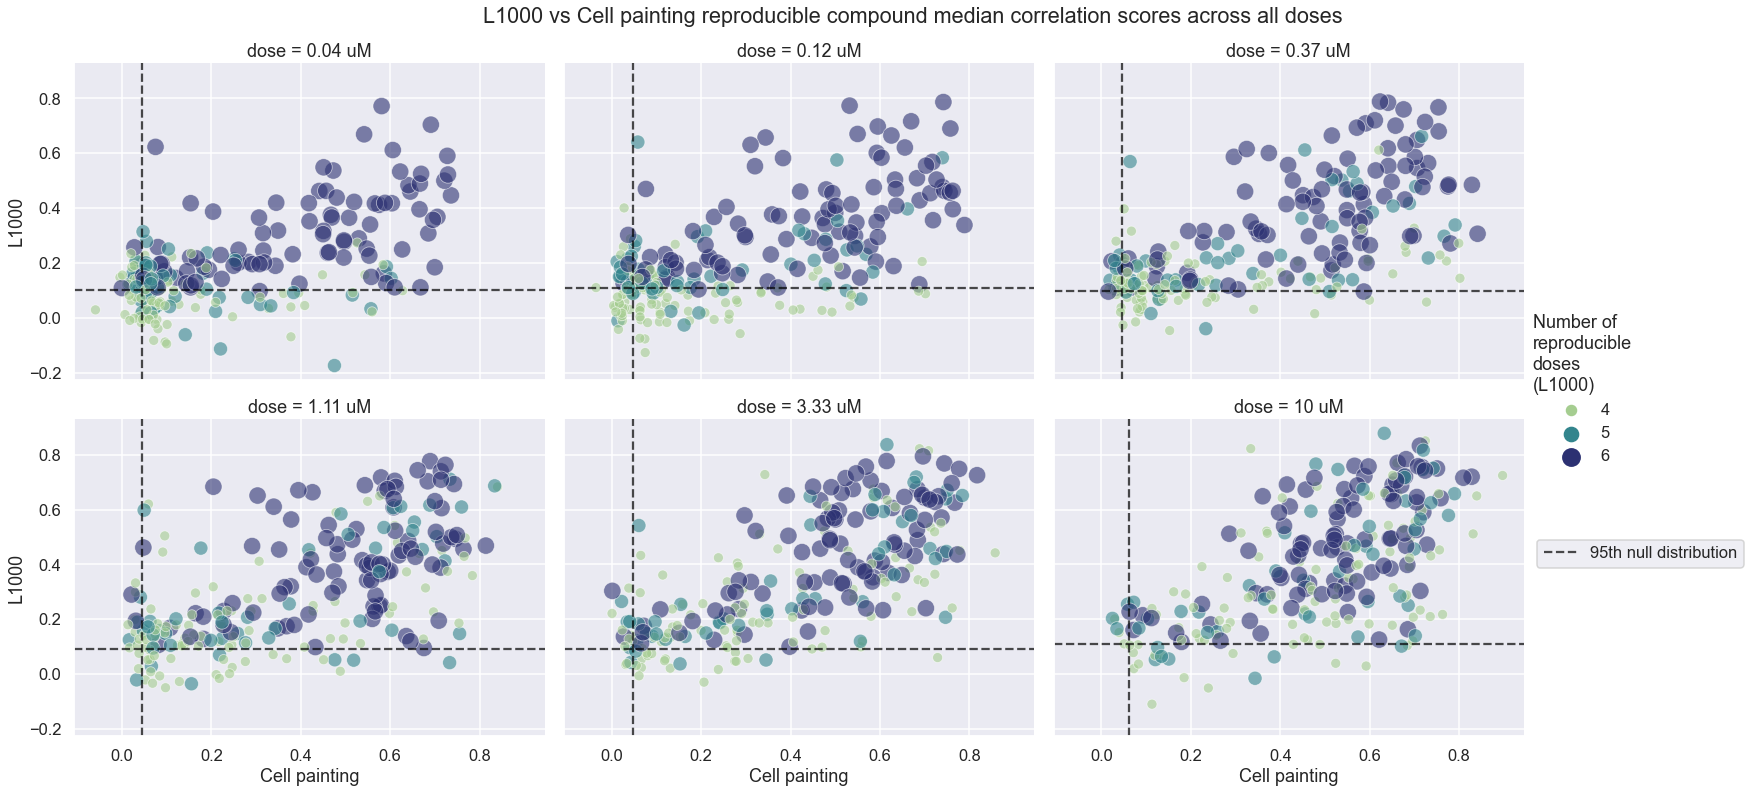

In [44]:
plot_median_scores(df_L1_cp_stat_med, L1000_95pct, cp_95pct, 
                   "L1000 vs Cell painting reproducible compound median correlation scores across all doses",
                   'L1000_cp_figures', 'stat_sign_med_scores_plot1b.png',
                   hue = 'L1000', alp =0.6, size =(100,300))

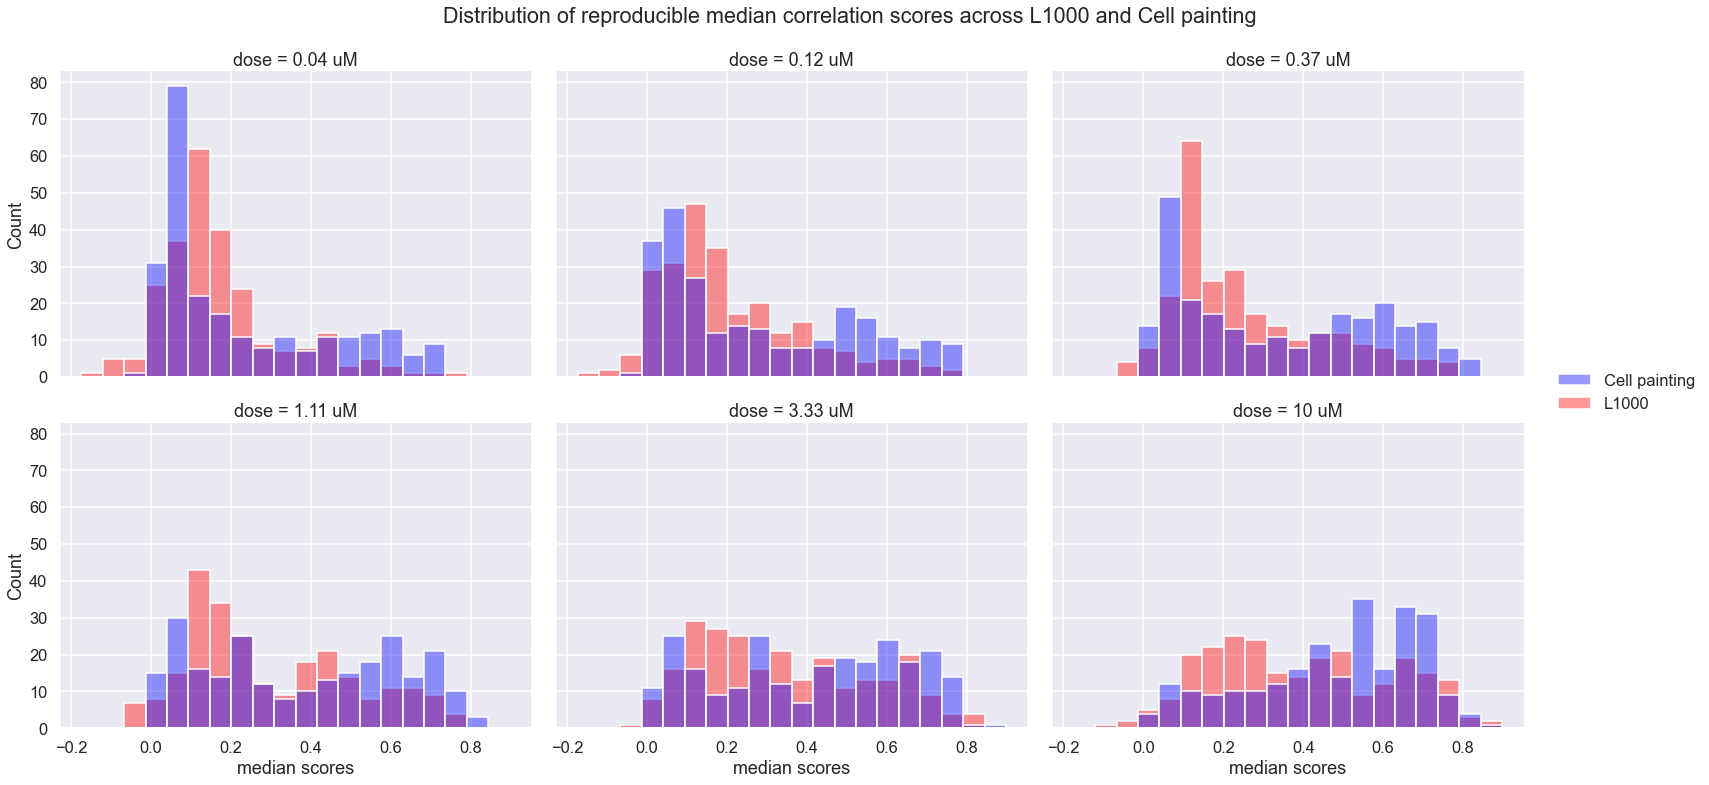

In [45]:
plot_median_distribution(df_cp_L1_stat_melt, 'Distribution of reproducible median correlation scores across L1000 and Cell painting', 
                         'L1000_cp_figures', 'stat_med_score_dist.png', plot_type = "hist")

### - Number of compounds with reproducible median scores for Cell painting and L1000 across all doses

In [46]:
def reproducible_no_of_cpd(df_L1, df_cp):
    """
    This function returns a dataframe that includes number of compounds 
    with reproducible median scores in each of the 6 doses for both cell painting and L1000
    """
    columns = ['0.04 uM','0.12 uM','0.37 uM','1.11 uM','3.33 uM','10 uM']
    no_of_L1_cpd = {col:df_L1.loc[(df_L1[col] <= 0.05)].shape[0] for col in columns}
    no_of_cp_cpd = {col:df_cp.loc[(df_cp[col] <= 0.05)].shape[0] for col in columns}
    df_cpd = pd.DataFrame.from_dict(no_of_L1_cpd, orient='index', columns = ['L1000'])
    df_cpd['Cell painting'] = no_of_cp_cpd.values()
    
    return df_cpd

In [47]:
df_cpd = reproducible_no_of_cpd(df_L1_pvals, df_cp_pvals)

In [48]:
def plot_no_of_cpd_dose(df, path, file_name):
    
    """Plot number of compounds with reproducible median scores for Cell painting and L1000 per dose"""
    if not os.path.exists(path):
        os.mkdir(path)   
    fig, axes = plt.subplots(2, 3, sharey=True)
    fig.suptitle('Number of compounds with reproducible median correlation scores')
    fig.subplots_adjust(top=.91)
    axes = axes.flatten()
    fig.set_size_inches(22.7, 12.27)
    columns = ['0.04 uM','0.12 uM','0.37 uM','1.11 uM','3.33 uM','10 uM']
    for idx, col in enumerate(columns):
        sns.barplot(ax=axes[idx], x=df.loc[col].index, y=df.loc[col].values, palette=['#eb3434', '#eb7a34'])
        axes[idx].set_title(df.loc[col].name)
    [axes[i].set_ylabel("Number of compounds") for i in range(0, 1)]
    [axes[i].set_ylabel("Number of compounds") for i in range(3, 4)] 
    plt.savefig(os.path.join(path, file_name))
    plt.show()

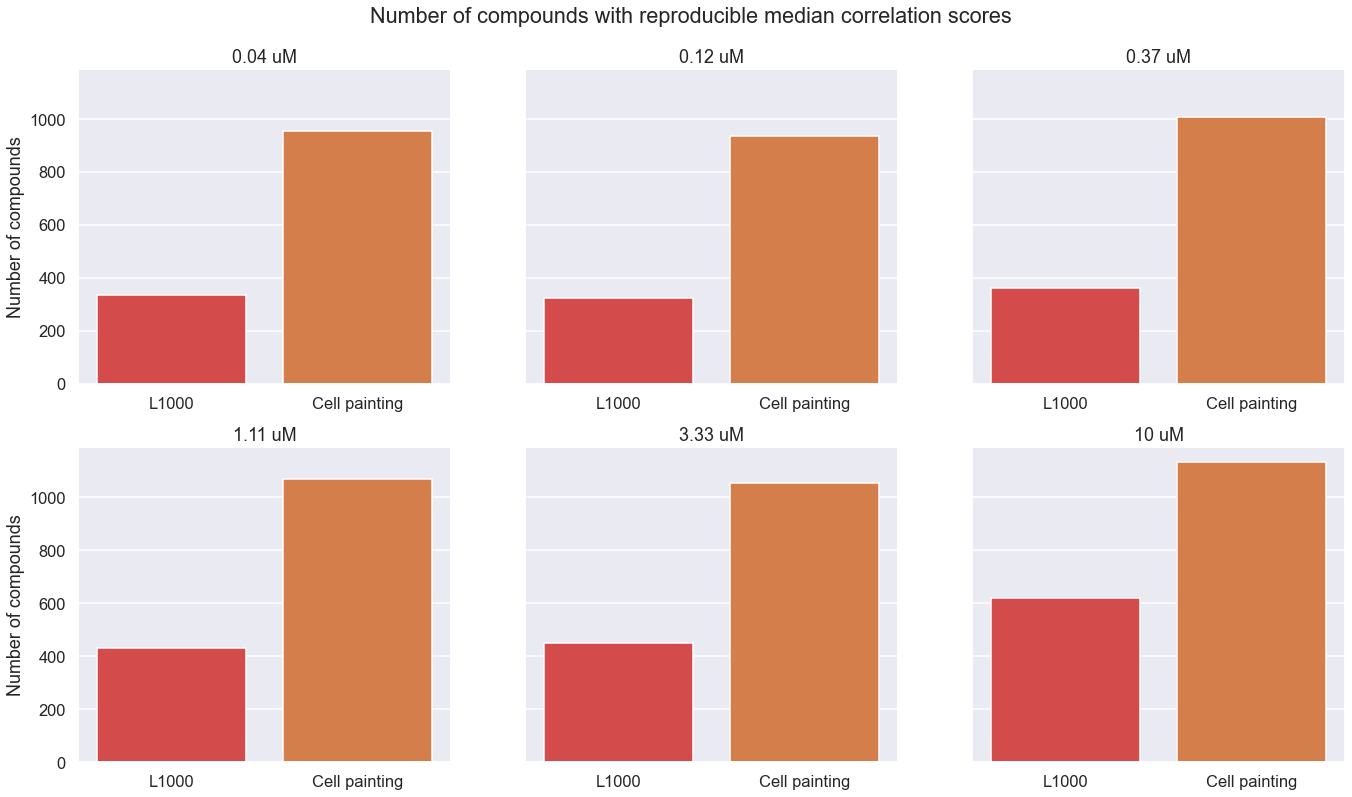

In [49]:
plot_no_of_cpd_dose(df_cpd, 'L1000_cp_figures', 'no_of_reprod_cpd_per_dose.png')

In [50]:
def plot_no_of_cpd(df, path, file_name):
    
    """Plot number of compounds with reproducible median correlation scores for Cell painting and L1000"""
    if not os.path.exists(path):
        os.mkdir(path)
    fig, axes = plt.subplots(1, 2, sharey=True)
    fig.suptitle('Compounds with reproducible median correlation scores')
    fig.subplots_adjust(top=.80)
    axes = axes.flatten()
    fig.set_size_inches(18.7, 5.27)
    for idx, col in enumerate(['L1000', 'Cell painting']):
        sns.barplot(ax=axes[idx], x=df[col].index, y=df[col].values, palette=['gray'])
        axes[idx].set_title(df_cpd[col].name)
    [axes[i].set_ylabel("% Percent of compounds") for i in range(0, 1)]
    plt.savefig(os.path.join(path, file_name))
    plt.show()

In [51]:
##'#eb3434', '#eb7a34', '#ebae34', '#a45445', '#ea7862', '#eabe62'

In [52]:
len(df_cp_L1_melt['cpd'].unique())

1327

In [53]:
df_cpd = (df_cpd/len(df_cp_L1_melt['cpd'].unique())) * 100

In [54]:
df_cpd

L1000  Cell painting
0.04 uM  25.395629      72.117558
0.12 uM  24.491334      70.685757
0.37 uM  27.430294      75.885456
1.11 uM  32.629992      80.708365
3.33 uM  33.911078      79.577995
10 uM    46.872645      85.455916

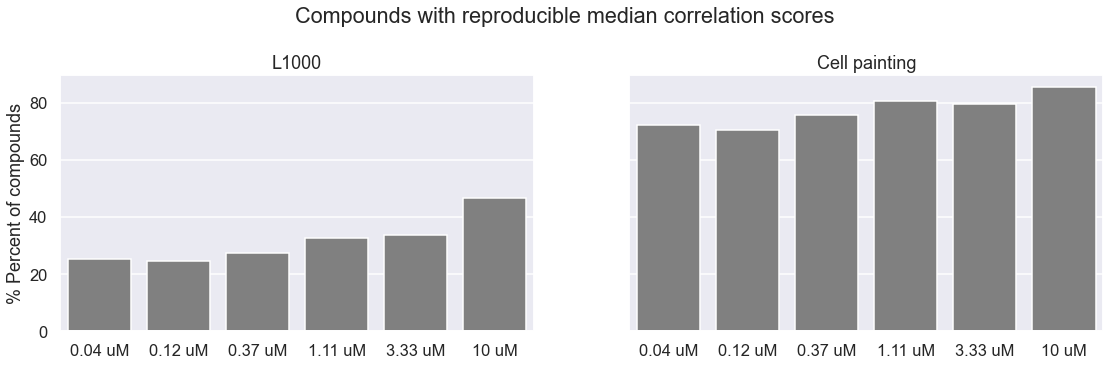

In [55]:
plot_no_of_cpd(df_cpd, 'L1000_cp_figures', 'no_of_reproducible_cpd.png')

### Visualizing TAS, MAS and signature strength scores for L1000 vs Cell painting

In [56]:
def merge_L1000_CP_2(df_cp,df_L1):
    
    """Merge Cell painting and L1000 dataframes based on compounds and doses found in both dataframes"""
    
    cp_cpd = df_cp['cpd'].unique().tolist()
    L1_cpd = df_L1['cpd'].unique().tolist()
    all_cpds = [x for x in cp_cpd if x in L1_cpd]
    
    df_cp_scores =df_cp.loc[df_cp['cpd'].isin(all_cpds)].reset_index(drop=True)
    df_L1_scores = df_L1.loc[df_L1['cpd'].isin(all_cpds)].reset_index(drop=True)
    df_cp_scores.rename({'replicate_correlation':'median_scores_CP', 
                         'signature_strength':'Cell_painting_SS'}, axis = 1, inplace=True)
    df_L1_scores.rename({'replicate_correlation':'median_scores_L1000', 
                         'signature_strength':'L1000_SS'}, axis = 1, inplace=True)
    df_L1_cp = df_cp_scores.merge(df_L1_scores, on=['cpd', 'dose'])
    return df_L1_cp

In [57]:
df_L1_cp_all = merge_L1000_CP_2(df_cp_all,df_L1_all)

In [58]:
df_L1_cp_all[['No_of_reproducible_doses-Cell painting', 'No_of_reproducible_doses-L1000']] = \
df_L1_cp_med[['No_of_reproducible_doses-Cell painting', 'No_of_reproducible_doses-L1000']]

In [59]:
def plot_mas_vs_tas(df, title, L1_dmso_95pct, cp_dmso_95pct, path, file_name, hue = 'Cell painting', 
                    alp = 0.3, size =(50,300)):
    
    """Plot L1000 Transcriptional activity score (TAS) vs Cell Painting Morphological activity score (MAS)"""
    
    if not os.path.exists(path):
        os.mkdir(path)
    rel_plt = sns.relplot(data=df, x="MAS", y="TAS", col="dose", hue = 'No_of_reproducible_doses-' + hue,
                          size = 'No_of_reproducible_doses-' + hue, sizes= size, kind="scatter", 
                          palette=sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True),
                          col_wrap=3, height=5.5, aspect=1.3, alpha = alp)
    rel_plt.fig.suptitle(title)
    rel_plt.fig.subplots_adjust(top=.91)
    for idx in range(6):
        rel_plt.axes[idx].axhline(y = L1_dmso_95pct, ls='--', color = 'black', alpha = 0.8, label = '95th-DMSO TAS score')
        rel_plt.axes[idx].axvline(x = cp_dmso_95pct, ls='--', color = 'red', alpha = 0.8, label = '95th-DMSO MAS score')
    rel_leg = rel_plt._legend
    rel_leg.set_bbox_to_anchor([0.90, 0.51])
    plt.legend(bbox_to_anchor=(1.01, 0.495), loc='lower left')
    rel_plt.legend.set_title('Number of\nreproducible\ndoses\n' + '('+ hue +')')
    plt.savefig(os.path.join(path, file_name))
    plt.show()

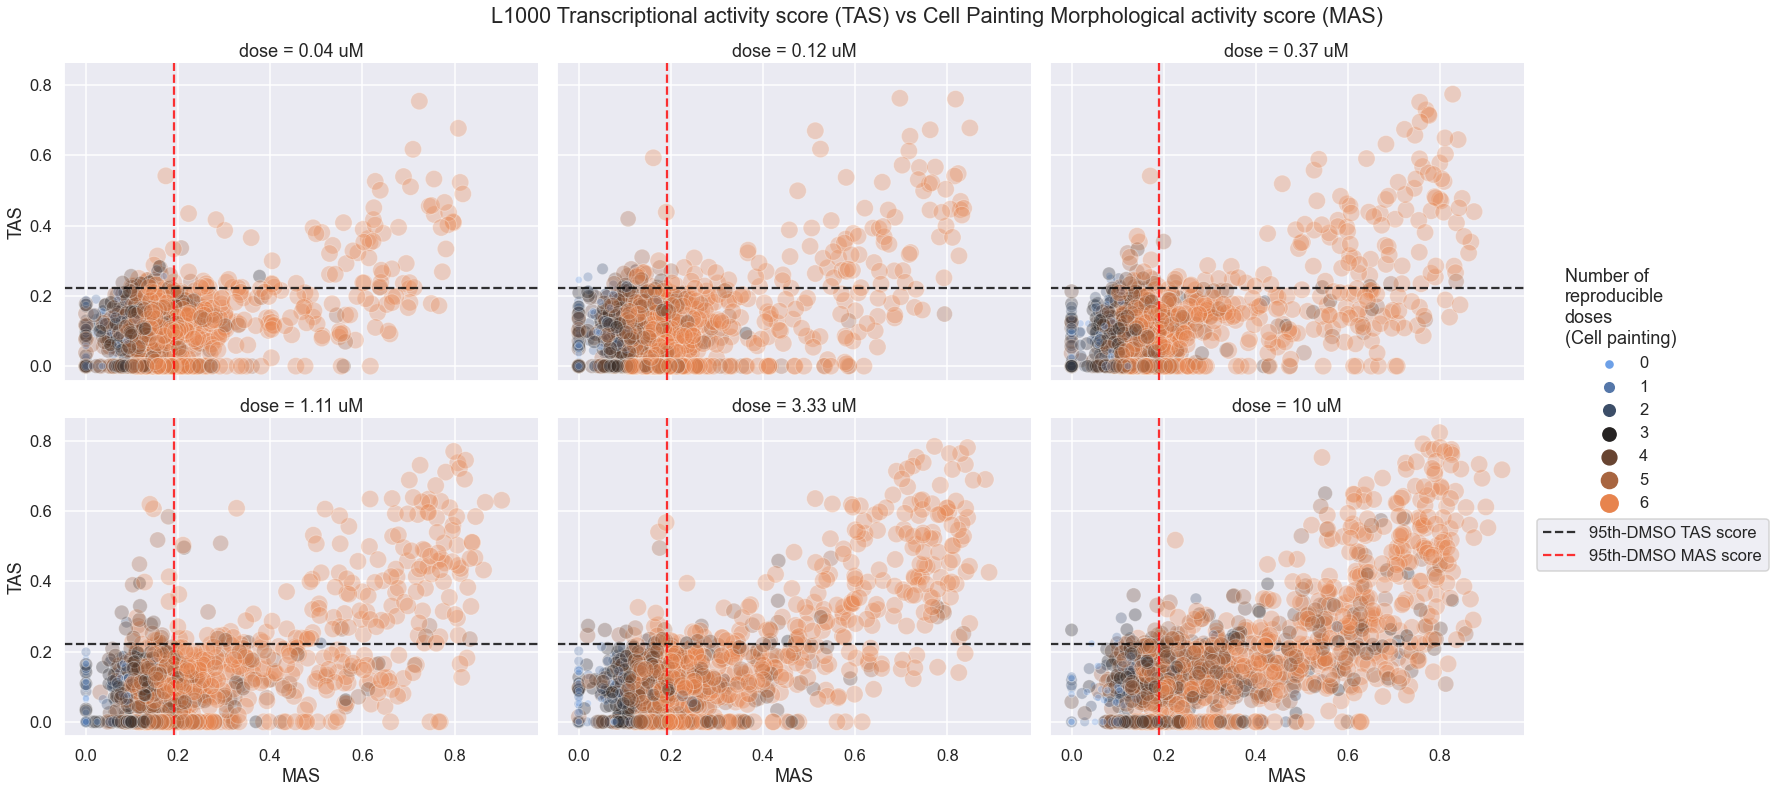

In [60]:
plot_mas_vs_tas(df_L1_cp_all, "L1000 Transcriptional activity score (TAS) vs Cell Painting Morphological activity score (MAS)",
               L1_dmso_95pct, cp_dmso_95pct, 'L1000_cp_figures', 'TAS_vs_MAS_1a.png')

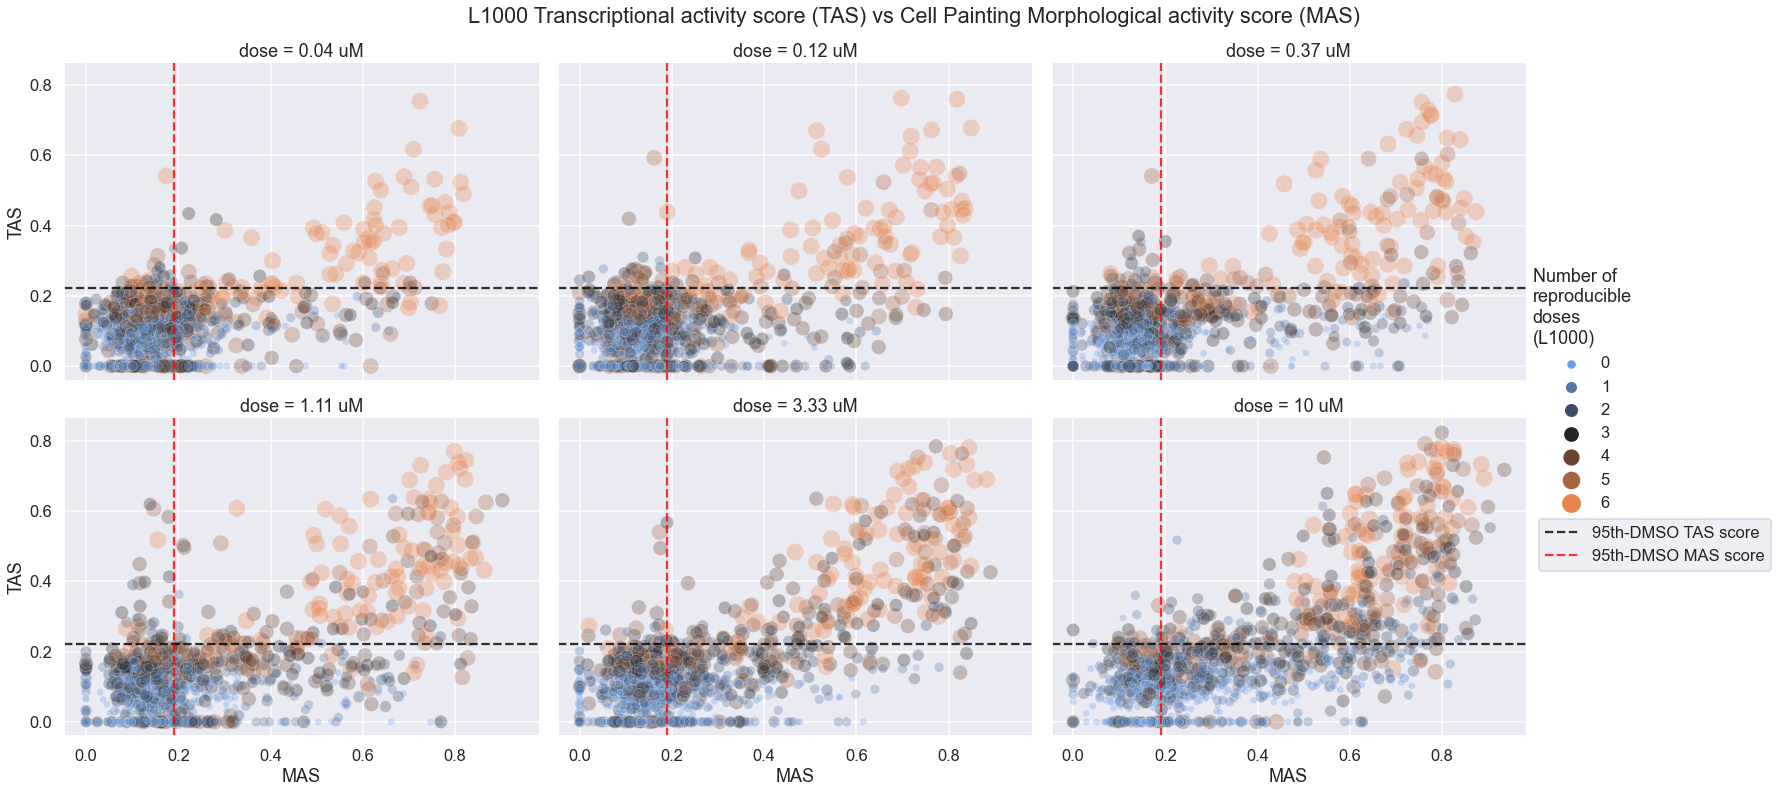

In [61]:
plot_mas_vs_tas(df_L1_cp_all, "L1000 Transcriptional activity score (TAS) vs Cell Painting Morphological activity score (MAS)",
               L1_dmso_95pct, cp_dmso_95pct, 'L1000_cp_figures', 'TAS_vs_MAS_1b.png', hue = 'L1000')

In [62]:
def plot_ss(df, title, path, file_name, hue = 'Cell painting', alp=0.3, size =(50,300)):
    
    """Plot L1000 vs Cell Painting signature strength"""
    if not os.path.exists(path):
        os.mkdir(path)
    rel_plt = sns.relplot(data=df, x='Cell_painting_SS', y='L1000_SS', col="dose", 
                          hue = 'No_of_reproducible_doses-' + hue, size = 'No_of_reproducible_doses-' + hue, 
                          sizes= size, kind="scatter", 
                          palette=sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True),
                          col_wrap=3, height=5.5, aspect=1.3, alpha = alp)
    rel_plt.fig.suptitle(title)
    rel_plt.fig.subplots_adjust(top=.91)
    rel_leg = rel_plt._legend
    rel_leg.set_bbox_to_anchor([0.90, 0.51])
    rel_plt.legend.set_title('Number of\nreproducible\ndoses\n' + '('+ hue +')')
    plt.savefig(os.path.join(path, file_name))
    plt.show()

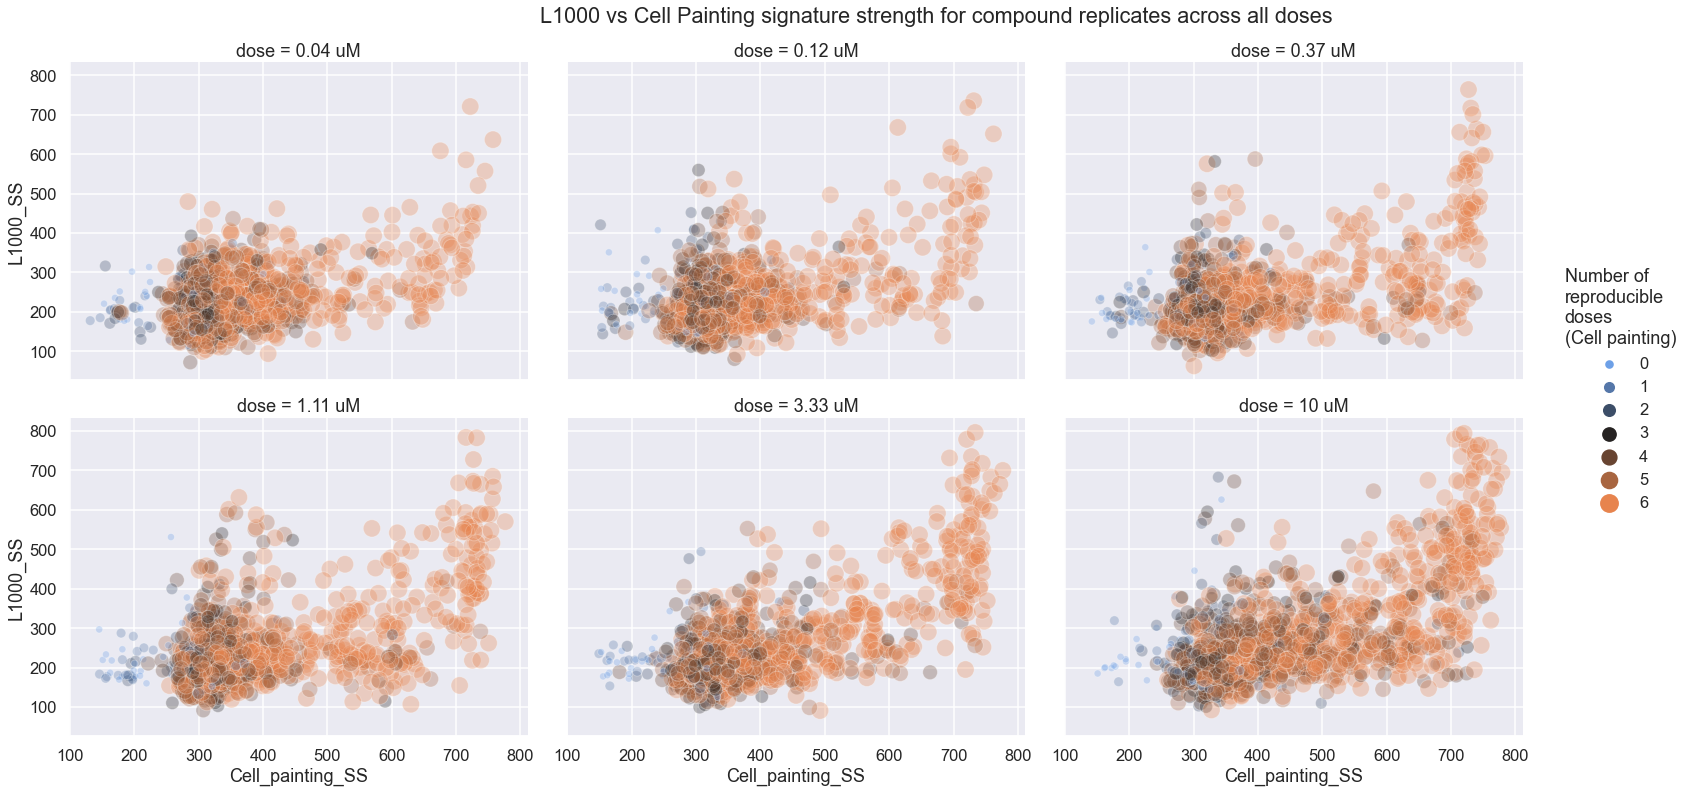

In [63]:
plot_ss(df_L1_cp_all, "L1000 vs Cell Painting signature strength for compound replicates across all doses",
                'L1000_cp_figures', 'L1000_SS_vs_CP_SS_1a.png')

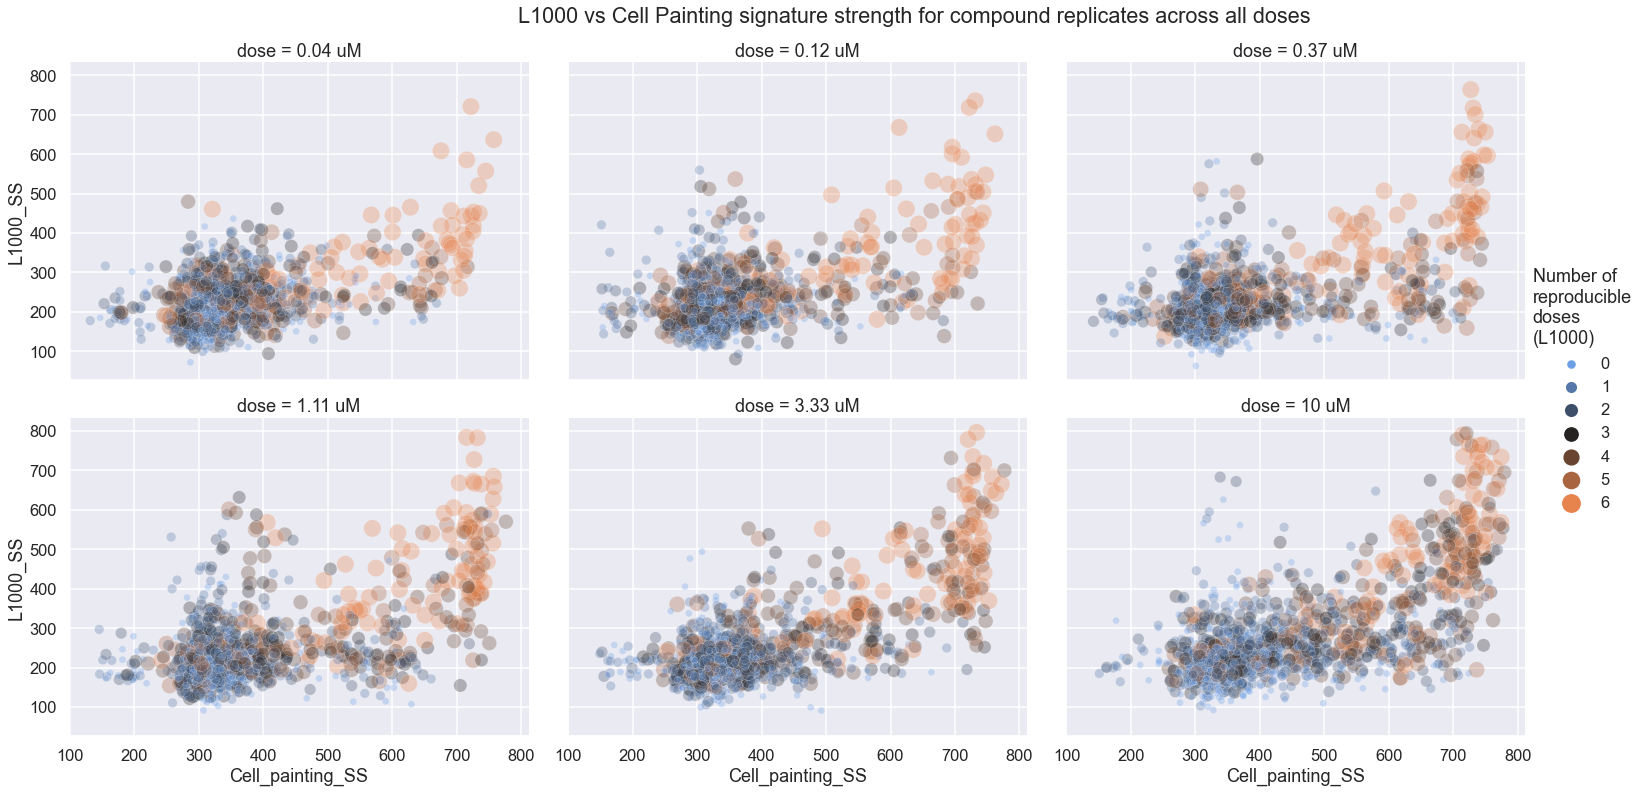

In [64]:
plot_ss(df_L1_cp_all, "L1000 vs Cell Painting signature strength for compound replicates across all doses",
                'L1000_cp_figures', 'L1000_SS_vs_CP_SS_1b.png', hue = 'L1000')

### - Compounds with high MAS but low TAS (i.e. TAS below 0.3 and MAS > 0.7)

In [65]:
df_highmas_lowtas = df_L1_cp_all[(df_L1_cp_all['TAS'] < 0.3) & (df_L1_cp_all['MAS'] > 0.7)].copy()

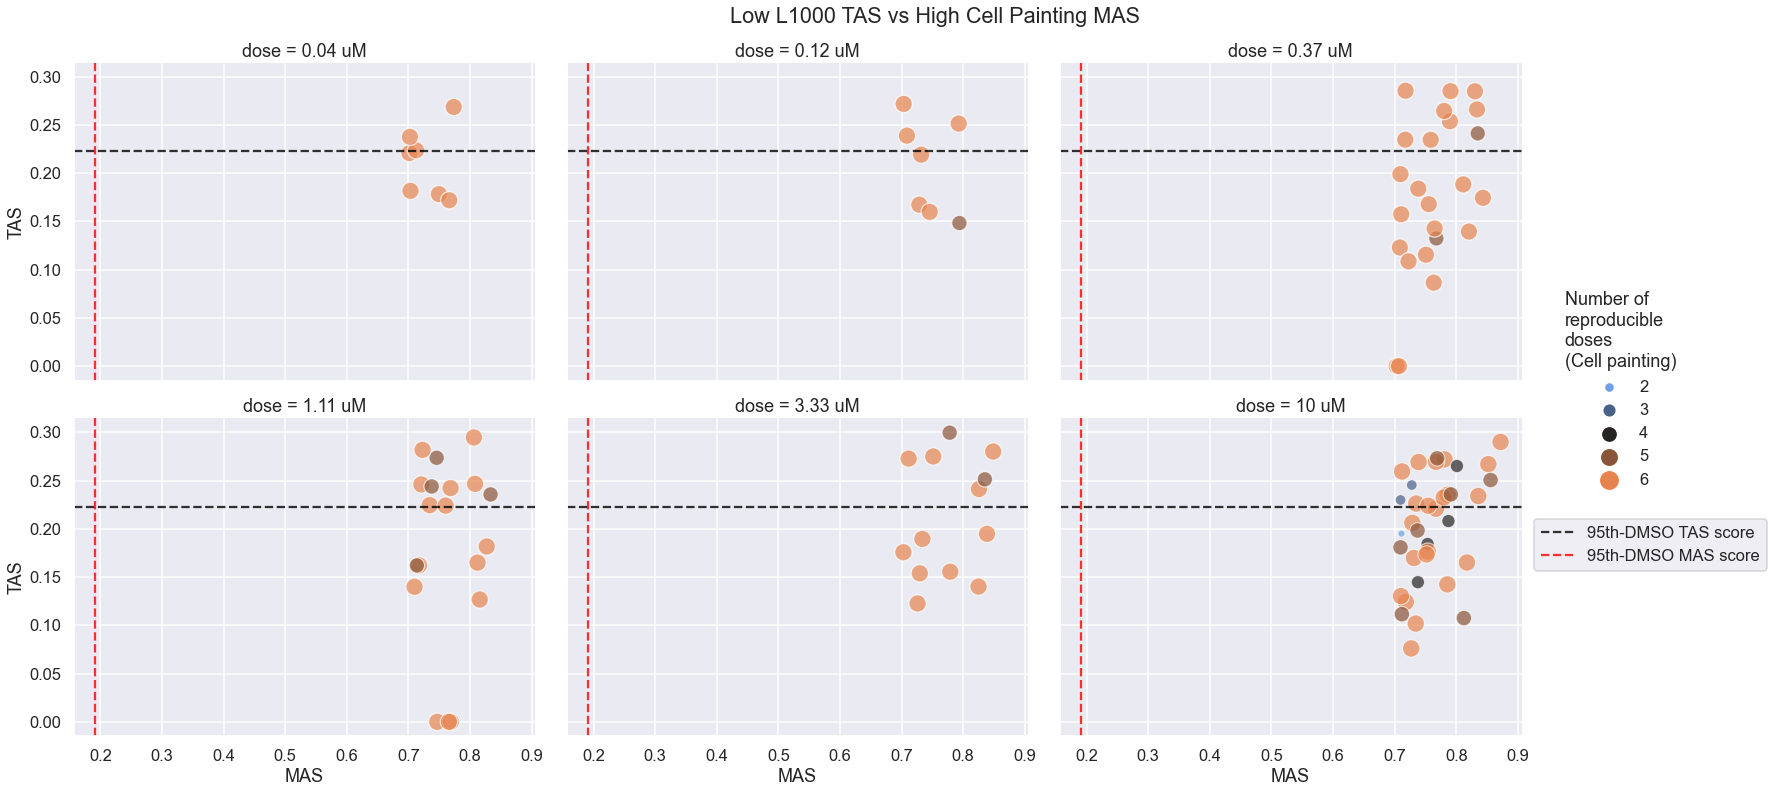

In [66]:
plot_mas_vs_tas(df_highmas_lowtas, "Low L1000 TAS vs High Cell Painting MAS",
               L1_dmso_95pct, cp_dmso_95pct, 'L1000_cp_figures', 'Low_TAS_vs_High_MAS_1a.png', alp = 0.7)

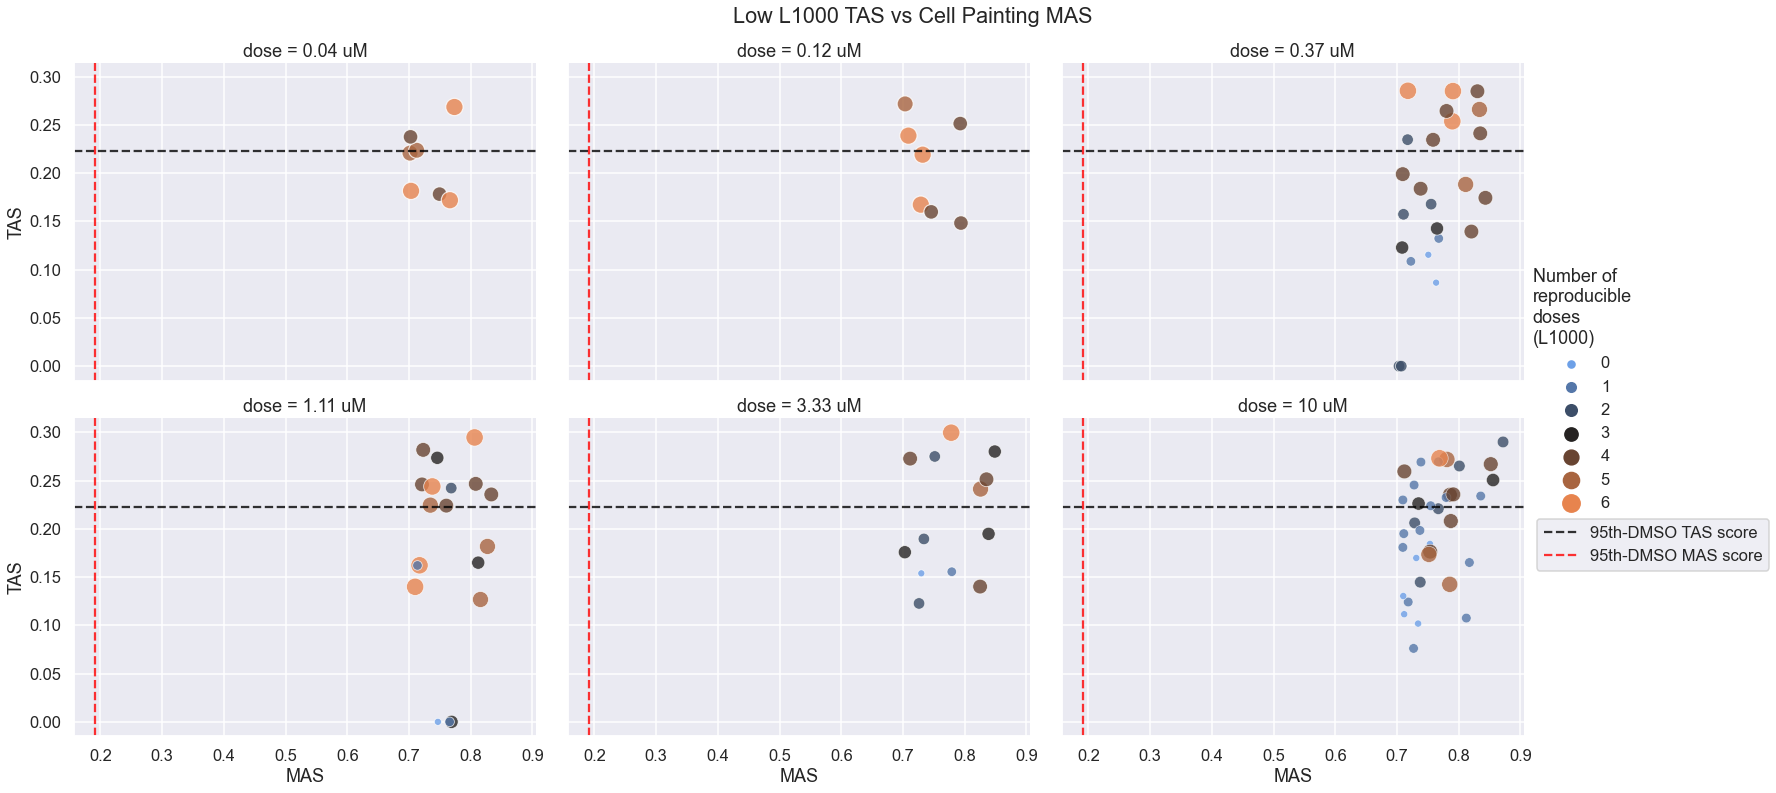

In [67]:
plot_mas_vs_tas(df_highmas_lowtas, "Low L1000 TAS vs Cell Painting MAS",
               L1_dmso_95pct, cp_dmso_95pct, 'L1000_cp_figures', 'Low_TAS_vs_High_MAS_1b.png', 
                hue = 'L1000',alp = 0.8)

In [68]:
df_lowmas_hightas = df_L1_cp_all[(df_L1_cp_all['MAS'] < 0.2) & (df_L1_cp_all['TAS'] > 0.5)].copy()

In [69]:
df_lowmas_hightas

cpd     dose  median_scores_CP  Cell_painting_SS  \
685           lasalocid  0.04 uM          0.075003             321.0   
2003    l-ergothioneine  0.12 uM          0.058396             359.2   
3330    l-ergothioneine  0.37 uM          0.063974             365.2   
4105            amg-517  1.11 uM          0.059216             433.2   
4625           iniparib  1.11 uM          0.047734             406.0   
4657    l-ergothioneine  1.11 uM          0.049568             346.8   
5183  tetrahydrouridine  1.11 uM          0.045648             338.2   
5984    l-ergothioneine  3.33 uM          0.060725             395.6   
6540        tofacitinib  3.33 uM          0.070028             411.0   

           MAS  median_scores_L1000    L1000_SS       TAS  \
685   0.173371             0.623312  460.333333  0.541651   
2003  0.161824             0.640835  536.666667  0.593002   
3330  0.170786             0.569795  503.000000  0.541345   
4105  0.178956             0.620393  537.333333  0.583829   
4625  0.155547             0.461702  568.000000  0.517828   
4657  0.146495             0.598063  601.500000  0.606487   
5183  0.138830             0.742995  505.000000  0.619397   
5984  0.173179             0.542090  526.666667  0.540299   
6540  0.189558             0.585557  537.666667  0.567377   

      No_of_reproducible_doses-Cell painting  No_of_reproducible_doses-L1000  
685                                        6                               6  
2003                                       6                               5  
3330                                       6                               5  
4105                                       5                               4  
4625                                       5                               6  
4657                                       6                               5  
5183                                       6                               3  
5984                                       6                               5  
6540                                       6                               3

### - Compounds (i.e. p-values below 0.05) with reproducible median correlation values in 1.11 - 10uM doses

### - Plot the MAS vs TAS;

### -  L1000 vs Cell painting Signature Strength

In [70]:
stat_cpds = df_stat_cp['cpd'].unique().tolist()

In [71]:
len(stat_cpds)

249

In [72]:
df_stat_all = df_L1_cp_all.loc[df_L1_cp_all['cpd'].isin(stat_cpds)].reset_index(drop=True)

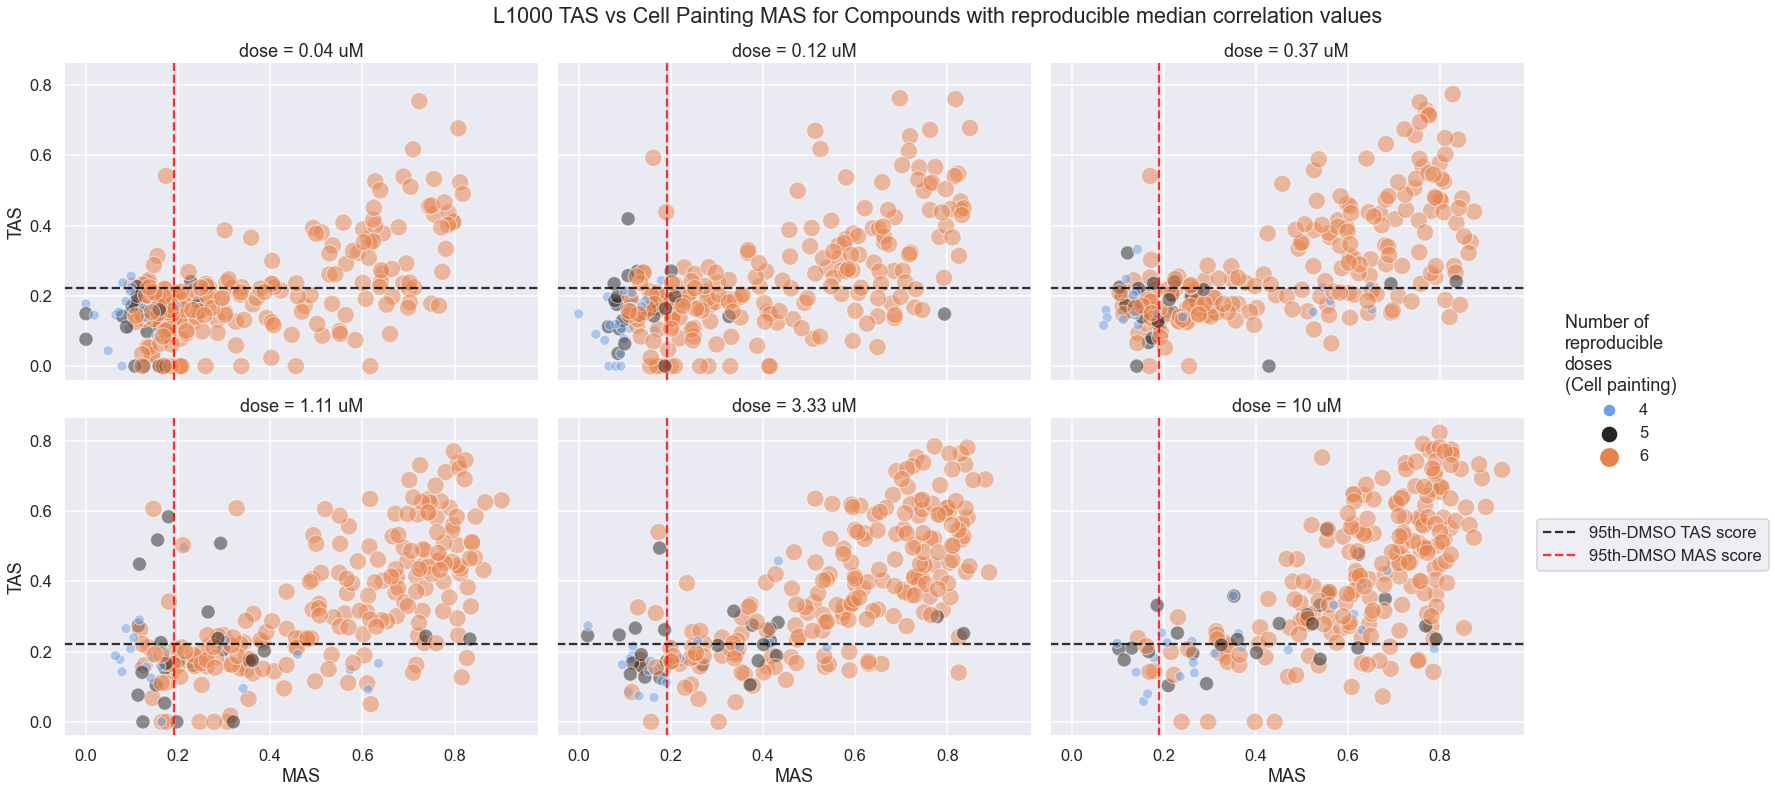

In [73]:
plot_mas_vs_tas(df_stat_all, "L1000 TAS vs Cell Painting MAS for Compounds with reproducible median correlation values",
               L1_dmso_95pct, cp_dmso_95pct, 'L1000_cp_figures', 'stat_TAS_vs_MAS_1a.png', alp=0.5, size =(100,300))

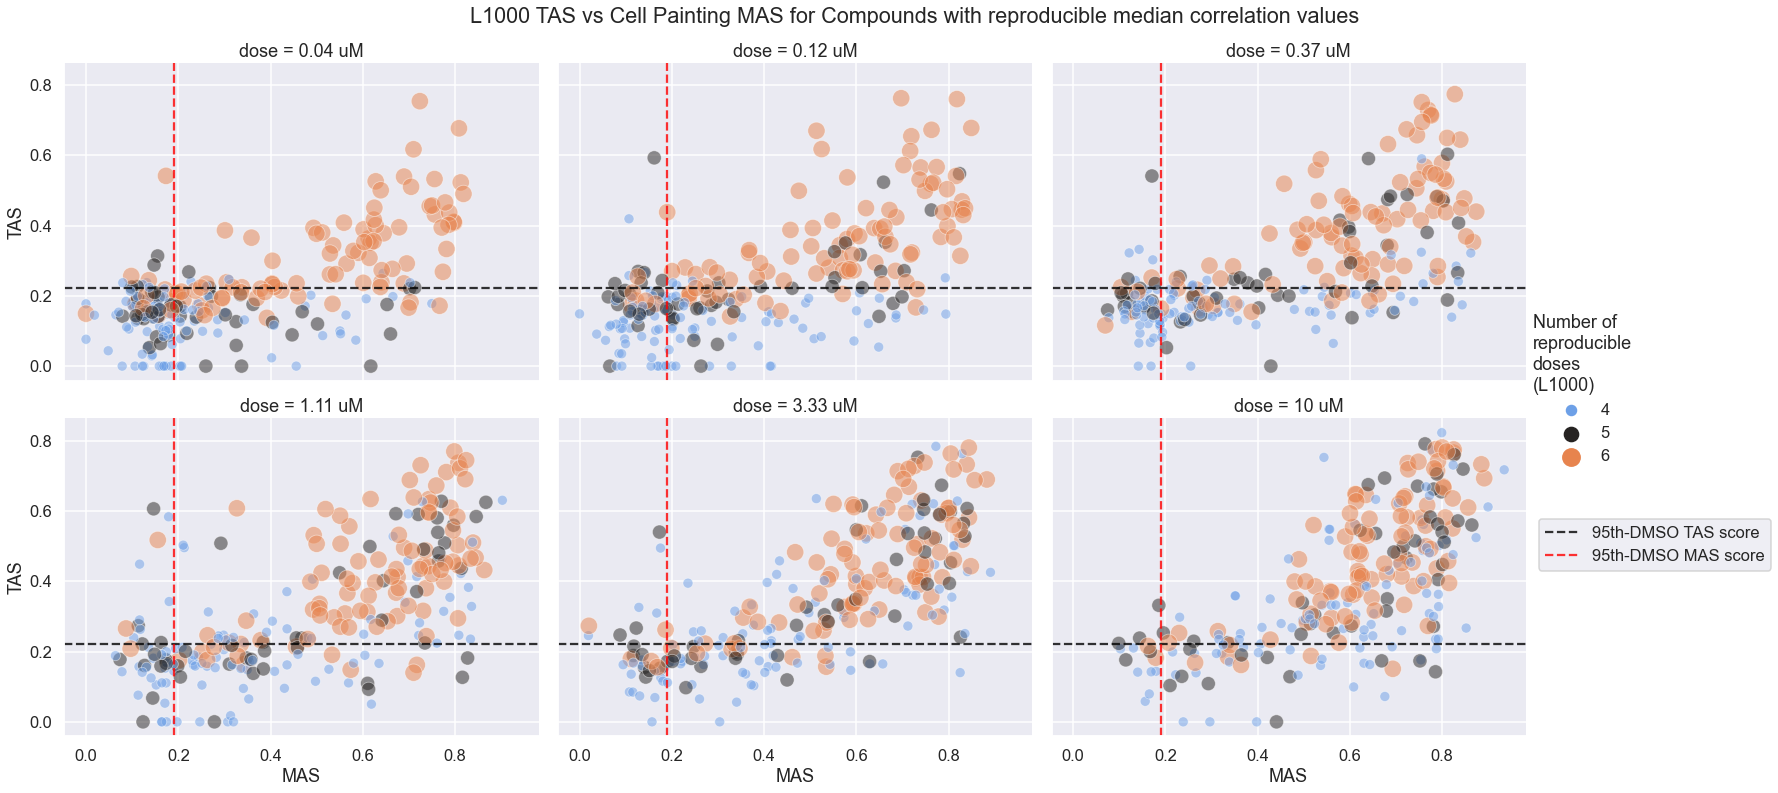

In [74]:
plot_mas_vs_tas(df_stat_all, "L1000 TAS vs Cell Painting MAS for Compounds with reproducible median correlation values",
               L1_dmso_95pct, cp_dmso_95pct, 'L1000_cp_figures', 'stat_TAS_vs_MAS_1b.png',
                hue = 'L1000', alp=0.5, size =(100,300))

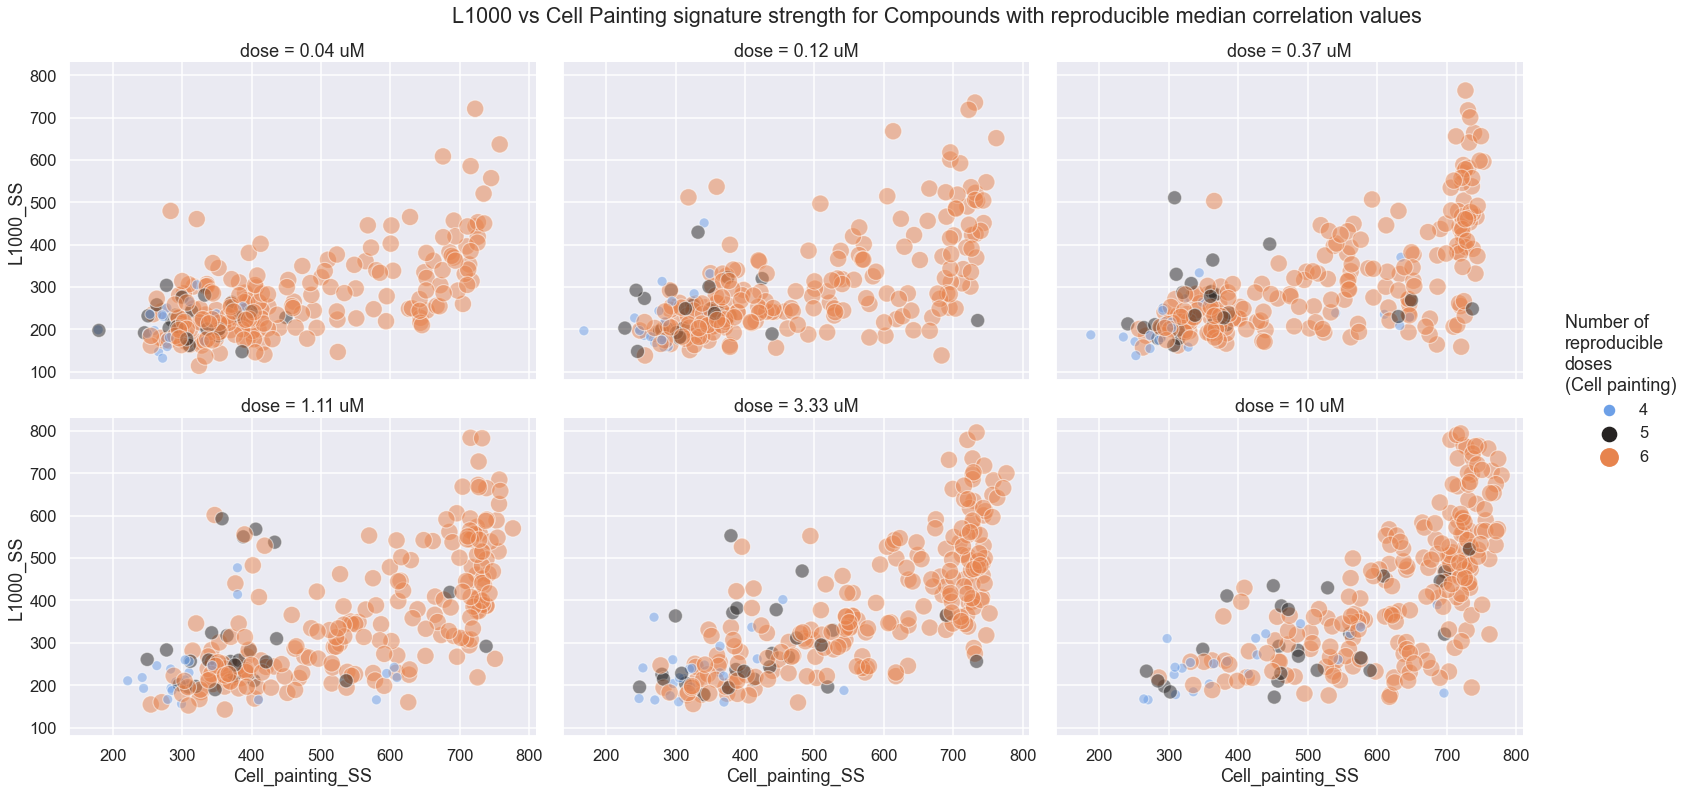

In [75]:
plot_ss(df_stat_all, "L1000 vs Cell Painting signature strength for Compounds with reproducible median correlation values",
                'L1000_cp_figures', 'stat_L1000_SS_vs_CP_SS_1a.png', alp=0.5, size =(100,300))

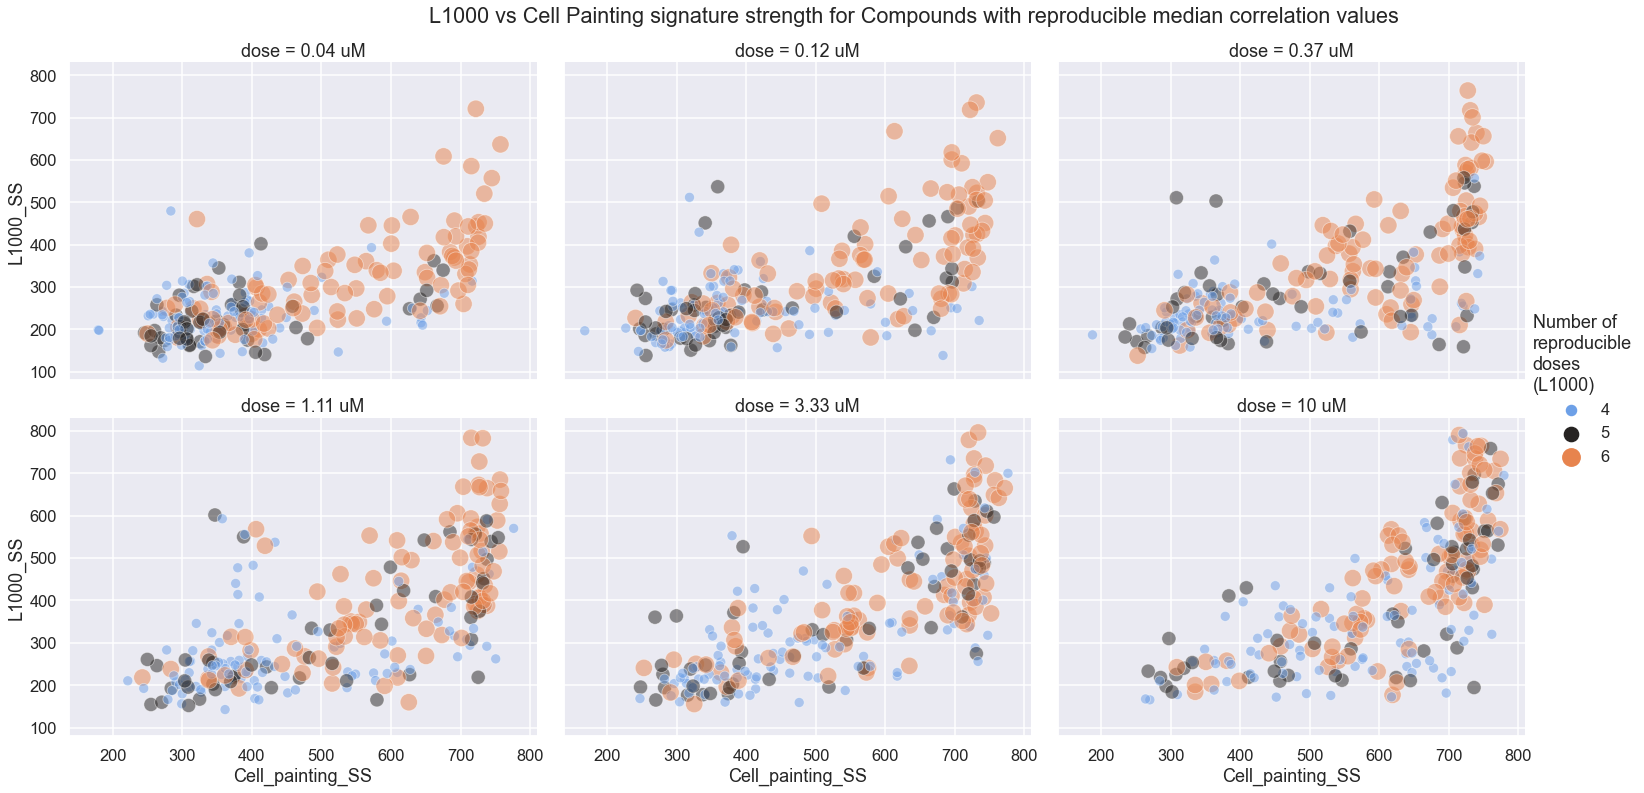

In [76]:
plot_ss(df_stat_all, "L1000 vs Cell Painting signature strength for Compounds with reproducible median correlation values",
        'L1000_cp_figures', 'stat_L1000_SS_vs_CP_SS_1b.png', 
        hue = 'L1000', alp=0.5, size =(100,300))